
╔══════════════════════════════════════════════════════════════════════════════╗
║          HOME CREDIT DEFAULT RISK - PRODUCTION SOLUTION v10.0                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Timestamp: 2025-12-29 16:04:43                                           ║
║  Data Path: /content/drive/MyDrive/KULIAH/Rakamin/            ║
╚══════════════════════════════════════════════════════════════════════════════╝

Utility functions loaded.

                              LOADING DATASETS

Mounted at /content/drive
Google Drive mounted.
   Loading application_train.csv (158.4 MB)... Shape: (307511, 122)
      Memory: 505.0MB -> 346.9MB (-31%)
   Loading application_test.csv (25.3 MB)... Shape: (48744, 121)
      Memory: 79.7MB -> 55.0MB (-31%)
   Loading bureau.csv (162.1 MB)... Shape: (1716428, 17)
      Memory: 472.8MB -> 369.7MB (-22%)
   Loading bureau_balance.csv (358.2 MB)... Shape: (27299925, 3)
      Memory: 1718.3MB -> 1431.9M

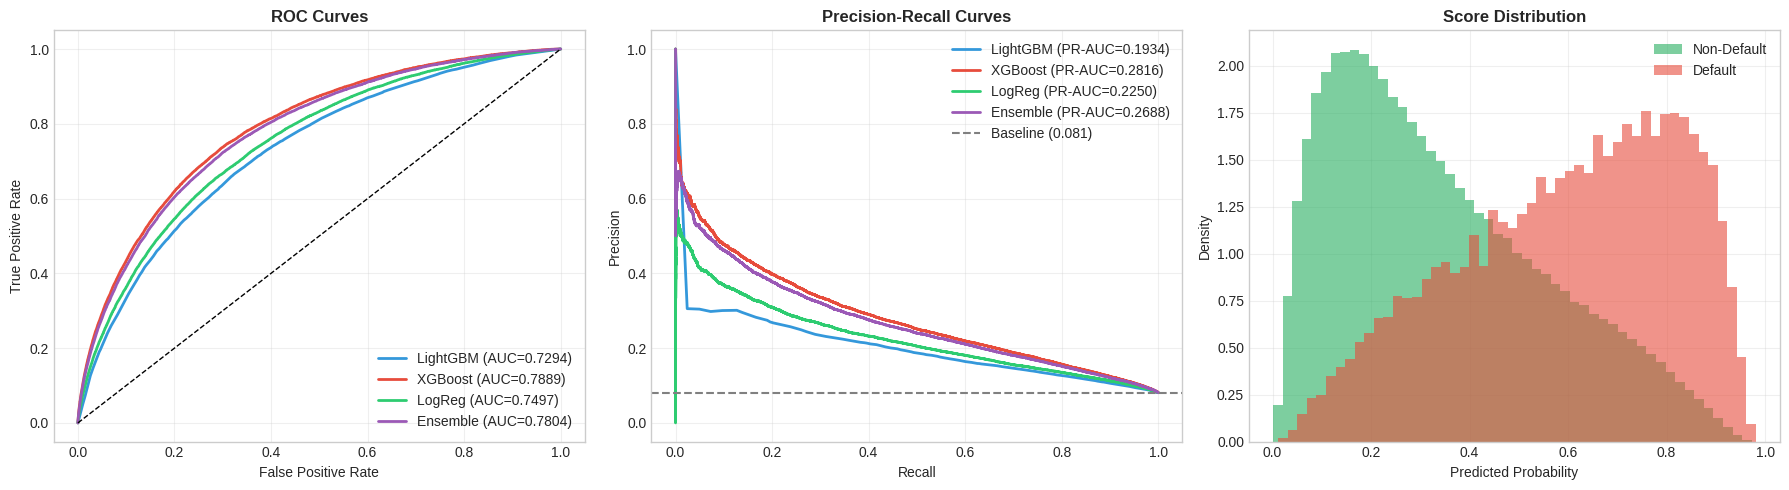

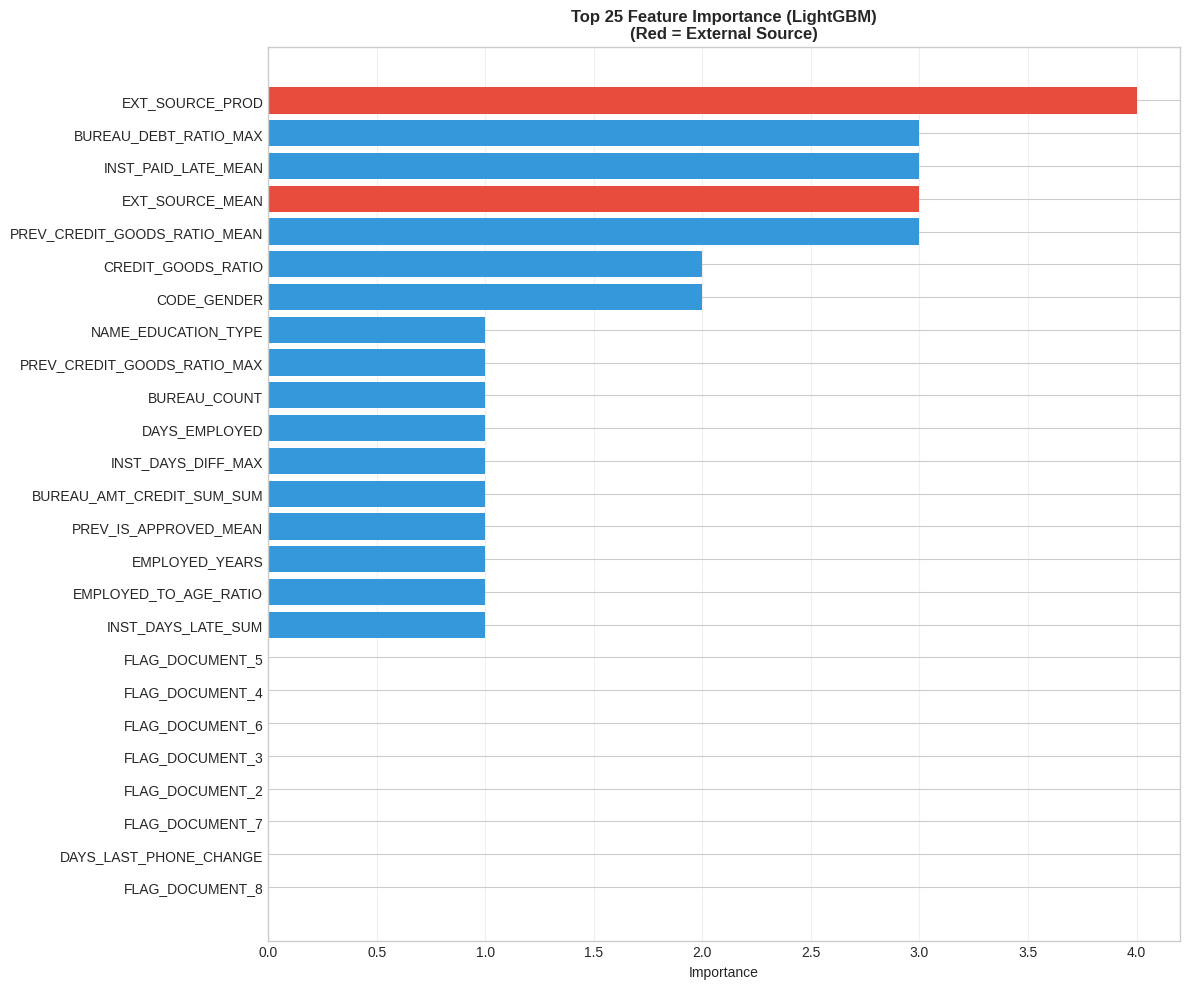

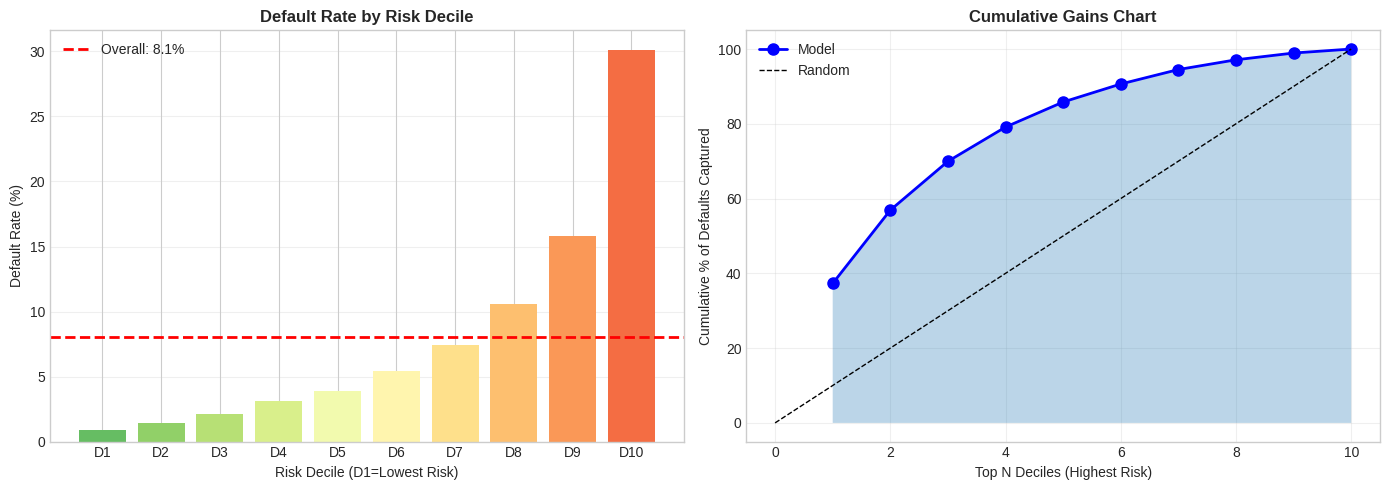

   Visualizations saved.

                    PROFIT-BASED THRESHOLD OPTIMIZATION

   Baseline (Approve All): $11,424,943,104

   Optimal Threshold: 0.709
   Net Benefit: $786,535,424
   Approval Rate: 90.1%
   Detection (Recall): 37.1%
   Precision: 30.3%


                         3-TIER POLICY ANALYSIS


THRESHOLD POLICY:
   AUTO_APPROVE : Score < 0.3903  (Bottom 60%)
   REVIEW       : Score 0.3903 - 0.6386  (Middle 25%)
   REJECT       : Score >= 0.6386  (Top 15%)



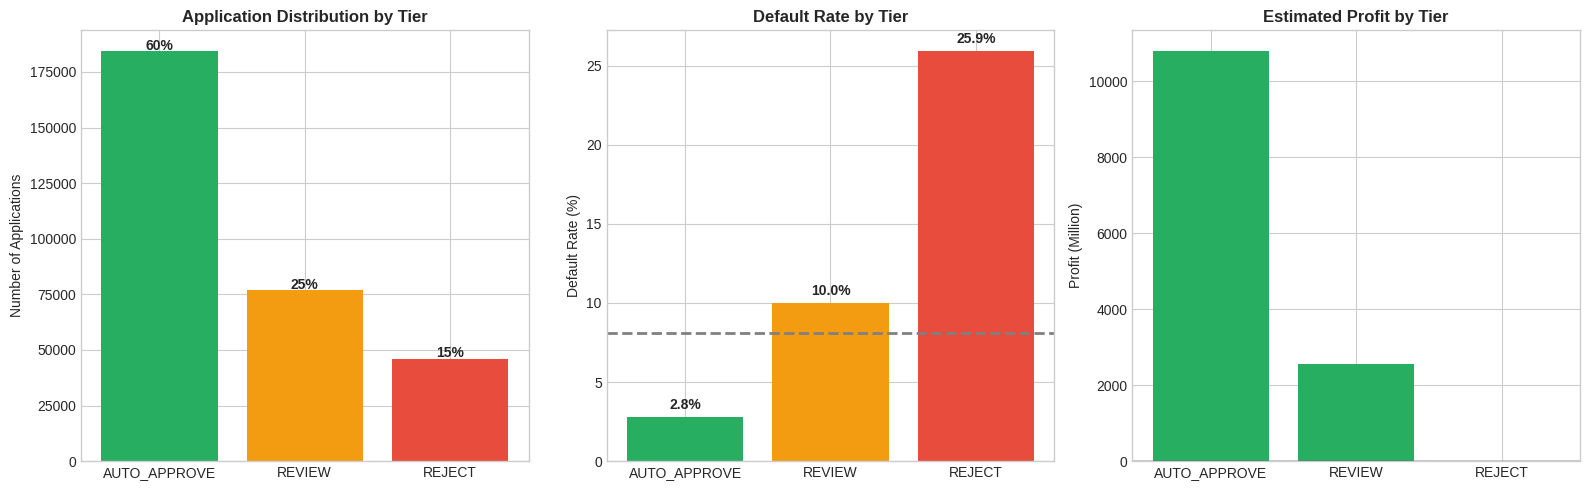


TIER STATISTICS:
Tier                  Apps      Pct   Defaults     Rate
---------------------------------------------------------------------------
AUTO_APPROVE       184,507    60.0%      5,181    2.81%
REVIEW              76,877    25.0%      7,679    9.99%
REJECT              46,127    15.0%     11,965   25.94%

---------------------------------------------------------------------------

PROFIT ANALYSIS:
   Baseline (Approve All):  $  9,289,172,992
   3-Tier Policy:           $ 13,346,974,454
   Improvement:             $  4,057,801,462 (+43.7%)


                         EXECUTIVE DASHBOARD



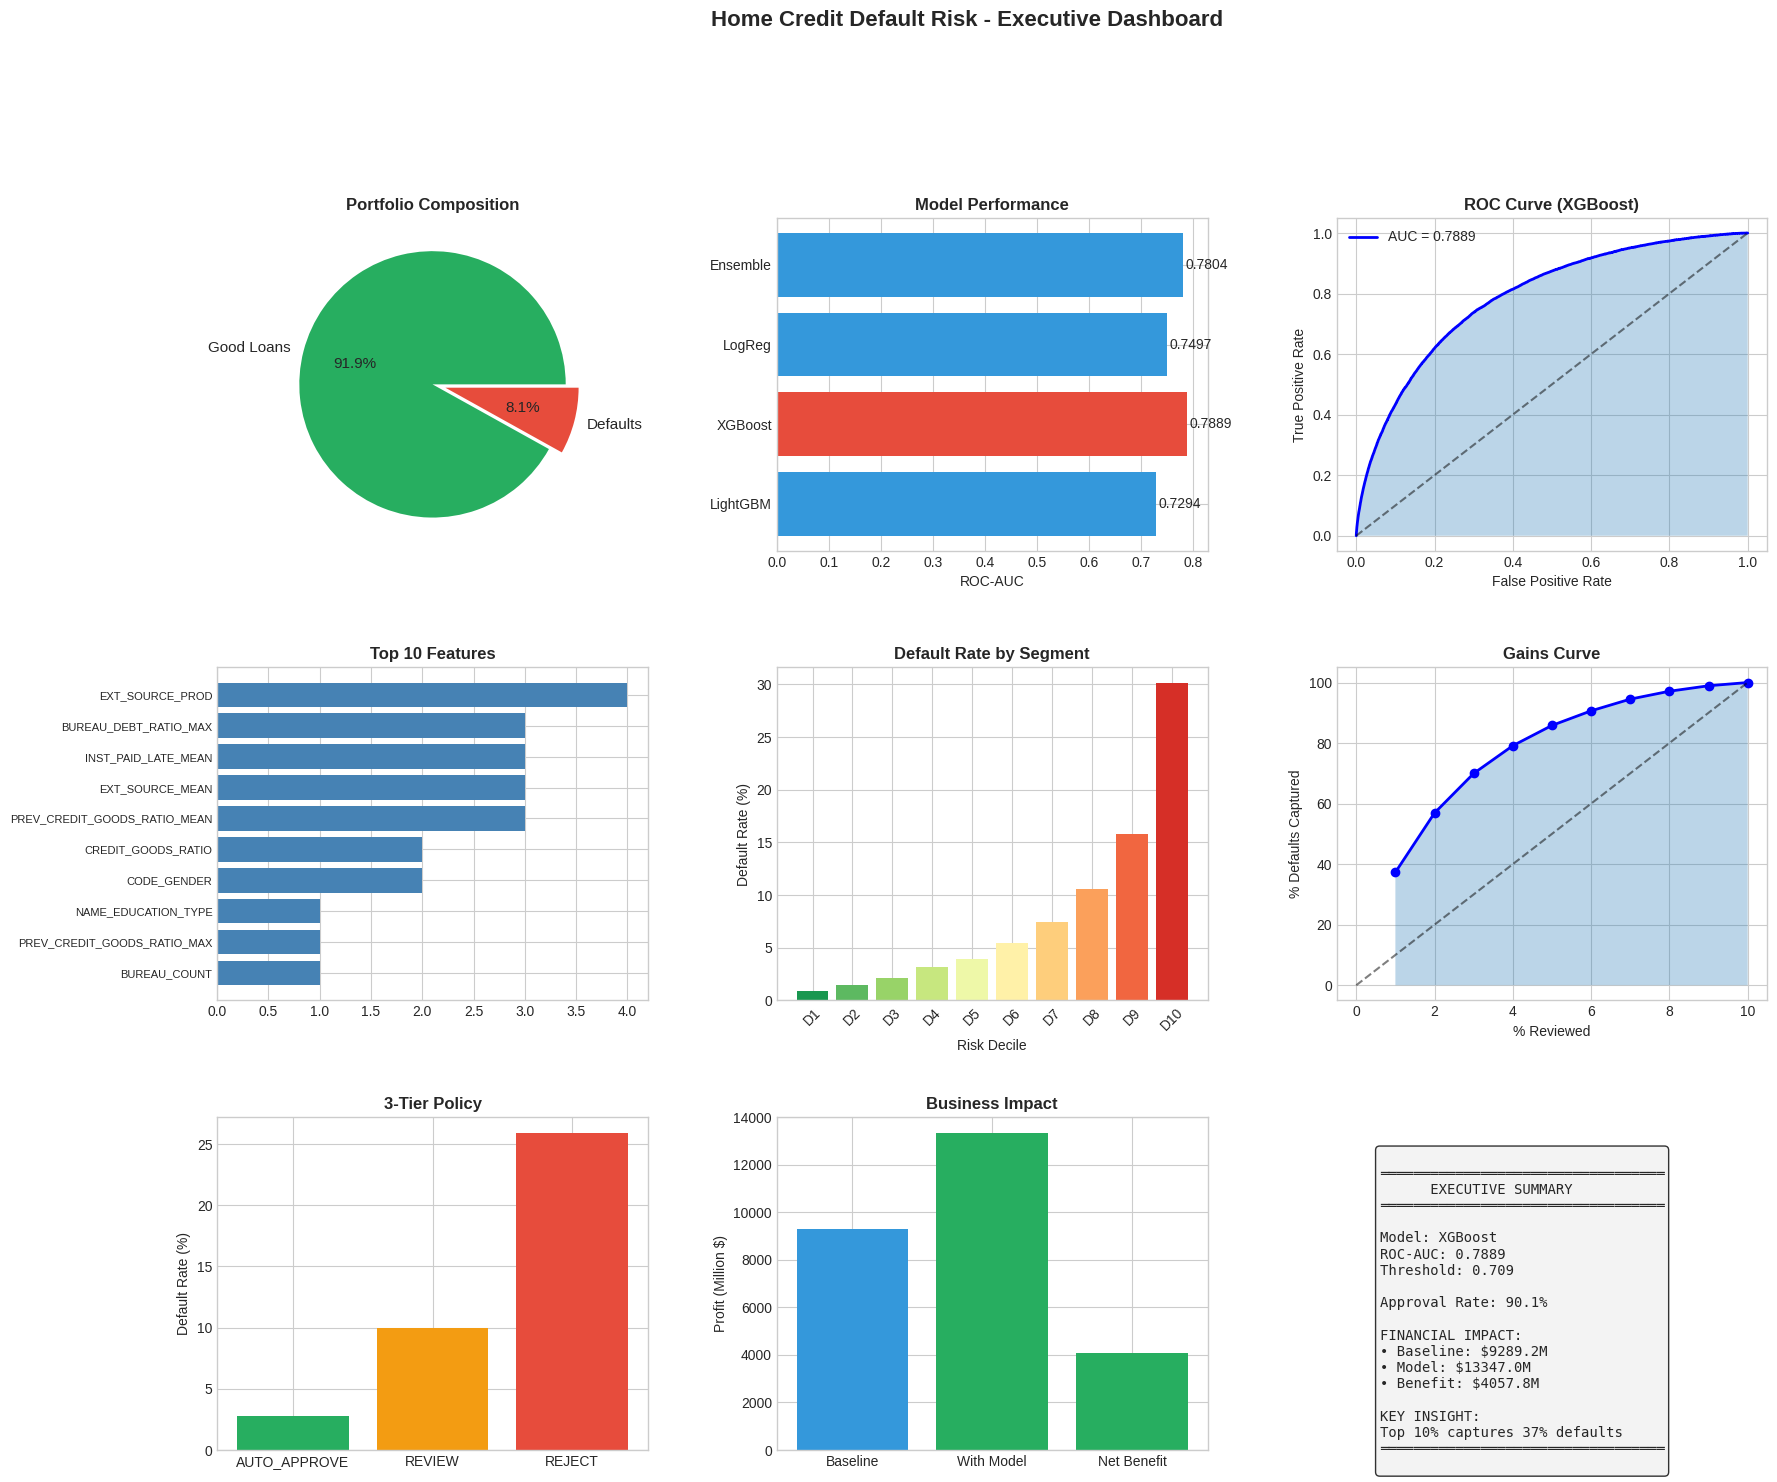


                              SAVING OUTPUTS

   submission.csv saved
   feature_importance.csv saved
   risk_deciles.csv saved
   tier_stats.csv saved
   model_config.json saved

╔══════════════════════════════════════════════════════════════════════════════╗
║                              FINAL SUMMARY                                    ║
╠══════════════════════════════════════════════════════════════════════════════╣

DATA:
   Train samples: 307,511
   Test samples:  48,744
   Features: 294

MODEL PERFORMANCE:
   Best Model: XGBoost
   ROC-AUC: 0.7889
   PR-AUC:  0.2816
   Brier Score: 0.1676

BUSINESS METRICS:
   Optimal Threshold: 0.709
   Approval Rate: 90.1%
   Net Benefit: $786,535,424

3-TIER POLICY:
   Auto-Approve: 60% of apps
   Review: 25% of apps
   Reject: 15% of apps
   Profit Improvement: +43.7%

OUTPUT FILES:
   - 01_model_performance.png
   - 02_feature_importance.png
   - 03_risk_deciles.png
   - 04_three_tier_policy.png
   - 05_executive_dashboard.png
   - submiss

23381

In [4]:
"""
================================================================================
HOME CREDIT DEFAULT RISK
================================================================================
"""

# ============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import os
import json
from datetime import datetime
from pathlib import Path

# Sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, brier_score_loss,
    precision_score, recall_score
)

# Boosting
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    # Data paths - SESUAIKAN DENGAN LOKASI DATA ANDA
    'DATA_PATH': '/content/drive/MyDrive/KULIAH/Rakamin/',  # Google Drive
    # 'DATA_PATH': '/kaggle/input/home-credit-default-risk/',  # Kaggle

    # Model parameters
    'N_FOLDS': 5,
    'RANDOM_STATE': 42,
    'EARLY_STOP_ROUNDS': 100,

    # Business parameters
    'PROFIT_RATE': 0.10,        # 10% profit on good loans
    'LGD': 0.40,                # 40% loss on defaults
    'INTEREST_RATE': 0.12,      # 12% interest
    'LOSS_RATE': 0.80,          # 80% loss rate
    'REVIEW_COST': 50,          # $50 per manual review
    'MIN_APPROVAL_RATE': 0.75,  # Minimum 75% approval

    # Memory optimization
    'N_JOBS': 2,                # Limit parallel jobs for memory
    'USE_FLOAT32': True,        # Use float32 instead of float64

    # Constants
    'EPS': 1e-8,
    'MIN_CATEGORY_FREQ': 50,
}

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║          HOME CREDIT DEFAULT RISK - PRODUCTION SOLUTION v10.0                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}                                           ║
║  Data Path: {CONFIG['DATA_PATH'][:50]:<50}║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# CELL 2: UTILITY FUNCTIONS
# ============================================================================

def reduce_memory(df, verbose=True):
    """Reduce memory usage by optimizing data types."""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        reduction = 100 * (start_mem - end_mem) / start_mem if start_mem > 0 else 0
        print(f"      Memory: {start_mem:.1f}MB -> {end_mem:.1f}MB (-{reduction:.0f}%)")
    return df


def safe_divide(a, b, fill=0):
    """Safe division handling zeros."""
    return np.where(b != 0, a / b, fill)


def get_memory_usage():
    """Get current memory usage in GB."""
    try:
        import psutil
        return psutil.Process().memory_info().rss / 1024**3
    except:
        return 0


def safe_read_csv(filename, path, nrows=None):
    """Safe CSV reader with memory optimization."""
    filepath = os.path.join(path, filename)

    if not os.path.exists(filepath):
        print(f"   [WARNING] {filename}: Not found")
        return None

    try:
        size_mb = os.path.getsize(filepath) / (1024*1024)
        print(f"   Loading {filename} ({size_mb:.1f} MB)...", end=" ")

        df = pd.read_csv(filepath, nrows=nrows, on_bad_lines='skip')
        print(f"Shape: {df.shape}")
        df = reduce_memory(df, verbose=True)
        return df
    except Exception as e:
        print(f"   [ERROR] {filename}: {e}")
        return None


print("Utility functions loaded.")

# ============================================================================
# CELL 3: DATA LOADING
# ============================================================================

print("""
================================================================================
                              LOADING DATASETS
================================================================================
""")

# Mount Google Drive if in Colab
try:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
        print("Google Drive mounted.")
except:
    pass

DATA_PATH = CONFIG['DATA_PATH']

# Load all datasets
df_train = safe_read_csv('application_train.csv', DATA_PATH)
df_test = safe_read_csv('application_test.csv', DATA_PATH)
bureau = safe_read_csv('bureau.csv', DATA_PATH)
bureau_balance = safe_read_csv('bureau_balance.csv', DATA_PATH)
prev_app = safe_read_csv('previous_application.csv', DATA_PATH)
installments = safe_read_csv('installments_payments.csv', DATA_PATH)
pos_cash = safe_read_csv('POS_CASH_balance.csv', DATA_PATH)
credit_card = safe_read_csv('credit_card_balance.csv', DATA_PATH)

# Validate critical data
if df_train is None:
    raise FileNotFoundError("application_train.csv is required!")

df_train['TARGET'] = pd.to_numeric(df_train['TARGET'], errors='coerce').fillna(0).astype(np.int8)

# Summary
n_train, n_test = len(df_train), len(df_test) if df_test is not None else 0
target_dist = df_train['TARGET'].value_counts().to_dict()

print(f"""
================================================================================
DATA SUMMARY:
   Train: {n_train:,} rows x {df_train.shape[1]} columns
   Test:  {n_test:,} rows
   Target: {target_dist}
   Default Rate: {df_train['TARGET'].mean()*100:.2f}%
================================================================================
""")

gc.collect()

# ============================================================================
# CELL 4: DATA CLEANING
# ============================================================================

print("""
================================================================================
                              DATA CLEANING
================================================================================
""")

def clean_application_data(df):
    """Comprehensive data cleaning for Home Credit application data."""
    df = df.copy()
    eps = CONFIG['EPS']

    print("   [1/6] Fixing DAYS_EMPLOYED anomaly...")
    # DAYS_EMPLOYED: 365243 = unemployed/pensioner
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] == 365243).astype(np.int8)
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)

    print("   [2/6] Creating missing flags...")
    # Missing flags for important features
    important_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                      'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'OCCUPATION_TYPE']
    for col in important_cols:
        if col in df.columns:
            df[f'{col}_MISSING'] = df[col].isna().astype(np.int8)

    print("   [3/6] Binary encoding...")
    # Binary encoding
    df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 1, 'F': 0, 'XNA': 0}).fillna(0).astype(np.int8)
    df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0}).fillna(0).astype(np.int8)
    df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0}).fillna(0).astype(np.int8)

    print("   [4/6] Handling outliers...")
    # Cap outliers
    if 'AMT_INCOME_TOTAL' in df.columns:
        cap = df['AMT_INCOME_TOTAL'].quantile(0.99)
        df['INCOME_OUTLIER'] = (df['AMT_INCOME_TOTAL'] > cap).astype(np.int8)
        df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].clip(upper=cap)

    if 'AMT_CREDIT' in df.columns:
        cap = df['AMT_CREDIT'].quantile(0.99)
        df['AMT_CREDIT'] = df['AMT_CREDIT'].clip(upper=cap)

    print("   [5/6] Document counts...")
    # Document count
    doc_cols = [c for c in df.columns if c.startswith('FLAG_DOCUMENT_')]
    if doc_cols:
        df['DOCS_SUBMITTED_COUNT'] = df[doc_cols].sum(axis=1).astype(np.int8)

    print("   [6/6] Filling categorical NAs...")
    # Fill categorical missing
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('XNA')

    return df

# Apply cleaning
print("\nCleaning Training Data...")
df_train = clean_application_data(df_train)

if df_test is not None:
    print("\nCleaning Test Data...")
    df_test = clean_application_data(df_test)

print(f"\n   Cleaning complete. Train shape: {df_train.shape}")
gc.collect()

# ============================================================================
# CELL 5: FEATURE ENGINEERING - APPLICATION
# ============================================================================

print("""
================================================================================
                    FEATURE ENGINEERING - APPLICATION
================================================================================
""")

def create_app_features(df):
    """Create features from application data."""
    df = df.copy()
    eps = CONFIG['EPS']

    print("   [1/5] Time-based features...")
    # Time-based
    df['AGE_YEARS'] = (-df['DAYS_BIRTH'] / 365).astype(np.float32)
    df['EMPLOYED_YEARS'] = (-df['DAYS_EMPLOYED'] / 365).astype(np.float32)
    df['REGISTRATION_YEARS'] = (-df['DAYS_REGISTRATION'] / 365).astype(np.float32)
    df['ID_PUBLISH_YEARS'] = (-df['DAYS_ID_PUBLISH'] / 365).astype(np.float32)

    # Age groups
    df['AGE_GROUP'] = pd.cut(df['AGE_YEARS'],
                             bins=[0, 25, 35, 45, 55, 65, 100],
                             labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

    # Employment ratios
    df['EMPLOYED_TO_AGE_RATIO'] = (df['EMPLOYED_YEARS'] / (df['AGE_YEARS'] + eps)).astype(np.float32)
    df['LONG_TERM_EMPLOYED'] = (df['EMPLOYED_YEARS'] > 5).astype(np.int8)
    df['NEW_EMPLOYEE'] = (df['EMPLOYED_YEARS'] < 1).astype(np.int8)

    print("   [2/5] Financial ratios...")
    # Financial ratios
    df['CREDIT_INCOME_RATIO'] = (df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + eps)).astype(np.float32)
    df['ANNUITY_INCOME_RATIO'] = (df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + eps)).astype(np.float32)
    df['CREDIT_ANNUITY_RATIO'] = (df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + eps)).astype(np.float32)
    df['CREDIT_GOODS_RATIO'] = (df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + eps)).astype(np.float32)

    # Payment burden
    df['PAYMENT_BURDEN'] = (df['AMT_ANNUITY'] * 12 / (df['AMT_INCOME_TOTAL'] + eps)).astype(np.float32)
    df['CREDIT_TERM_YEARS'] = (df['AMT_CREDIT'] / (df['AMT_ANNUITY'] * 12 + eps)).astype(np.float32)

    # Downpayment
    df['DOWNPAYMENT'] = (df['AMT_GOODS_PRICE'] - df['AMT_CREDIT']).clip(lower=0).astype(np.float32)
    df['DOWNPAYMENT_RATIO'] = (df['DOWNPAYMENT'] / (df['AMT_GOODS_PRICE'] + eps)).astype(np.float32)

    # Risk flags
    df['HIGH_CREDIT_INCOME'] = (df['CREDIT_INCOME_RATIO'] > 4).astype(np.int8)
    df['HIGH_ANNUITY_INCOME'] = (df['ANNUITY_INCOME_RATIO'] > 0.5).astype(np.int8)
    df['ZERO_DOWNPAYMENT'] = (df['DOWNPAYMENT_RATIO'] < 0.01).astype(np.int8)

    print("   [3/5] External source features...")
    # External sources
    ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    df['EXT_SOURCE_MEAN'] = df[ext_cols].mean(axis=1).astype(np.float32)
    df['EXT_SOURCE_STD'] = df[ext_cols].std(axis=1).astype(np.float32)
    df['EXT_SOURCE_MIN'] = df[ext_cols].min(axis=1).astype(np.float32)
    df['EXT_SOURCE_MAX'] = df[ext_cols].max(axis=1).astype(np.float32)
    df['EXT_SOURCE_PROD'] = (df['EXT_SOURCE_1'].fillna(0.5) *
                              df['EXT_SOURCE_2'].fillna(0.5) *
                              df['EXT_SOURCE_3'].fillna(0.5)).astype(np.float32)
    df['EXT_SOURCE_WEIGHTED'] = (df['EXT_SOURCE_1'].fillna(0) * 0.2 +
                                  df['EXT_SOURCE_2'].fillna(0) * 0.4 +
                                  df['EXT_SOURCE_3'].fillna(0) * 0.4).astype(np.float32)
    df['EXT_SOURCE_NANCOUNT'] = df[ext_cols].isna().sum(axis=1).astype(np.int8)
    df['LOW_EXT_SOURCE'] = (df['EXT_SOURCE_MEAN'] < 0.3).astype(np.int8)
    df['HIGH_EXT_SOURCE'] = (df['EXT_SOURCE_MEAN'] > 0.6).astype(np.int8)

    print("   [4/5] Family & social features...")
    # Family
    df['INCOME_PER_PERSON'] = (df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'].replace(0, 1))).astype(np.float32)
    df['CREDIT_PER_PERSON'] = (df['AMT_CREDIT'] / (df['CNT_FAM_MEMBERS'].replace(0, 1))).astype(np.float32)
    df['HAS_CHILDREN'] = (df['CNT_CHILDREN'] > 0).astype(np.int8)
    df['CHILDREN_RATIO'] = (df['CNT_CHILDREN'] / (df['CNT_FAM_MEMBERS'].replace(0, 1) + eps)).astype(np.float32)

    # Social circle
    social_def_cols = [c for c in df.columns if 'DEF_' in c and 'OBS_' not in c]
    if social_def_cols:
        df['SOCIAL_DEF_SUM'] = df[social_def_cols].sum(axis=1).astype(np.float32)
        df['HAS_SOCIAL_DEFAULT'] = (df['SOCIAL_DEF_SUM'] > 0).astype(np.int8)

    print("   [5/5] Risk indicators...")
    # Location
    loc_cols = ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']
    loc_cols = [c for c in loc_cols if c in df.columns]
    if loc_cols:
        df['LOCATION_MISMATCH'] = df[loc_cols].sum(axis=1).astype(np.int8)

    # Composite risk score
    risk_cols = ['HIGH_CREDIT_INCOME', 'HIGH_ANNUITY_INCOME', 'ZERO_DOWNPAYMENT',
                 'LOW_EXT_SOURCE', 'NEW_EMPLOYEE']
    risk_cols = [c for c in risk_cols if c in df.columns]
    df['RISK_FLAG_COUNT'] = df[risk_cols].sum(axis=1).astype(np.int8)

    return df

# Apply feature engineering
print("\nEngineering features for Training Data...")
df_train = create_app_features(df_train)

if df_test is not None:
    print("\nEngineering features for Test Data...")
    df_test = create_app_features(df_test)

print(f"\n   Features created. Train shape: {df_train.shape}")
gc.collect()

# ============================================================================
# CELL 6: BUREAU AGGREGATION
# ============================================================================

print("""
================================================================================
                         BUREAU DATA AGGREGATION
================================================================================
""")

def aggregate_bureau(bureau_df, bb_df):
    """Comprehensive bureau data aggregation."""
    if bureau_df is None:
        return None

    bureau_df = bureau_df.copy()
    eps = CONFIG['EPS']

    print("   [1/4] Processing bureau_balance...")
    # Bureau Balance aggregation
    if bb_df is not None:
        bb = bb_df[bb_df['MONTHS_BALANCE'] <= 0].copy()
        status_map = {'C': 0, 'X': 0, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
        bb['STATUS_NUM'] = bb['STATUS'].map(status_map).fillna(0).astype(np.int8)
        bb['HAS_DPD'] = (bb['STATUS_NUM'] > 0).astype(np.int8)

        bb_agg = bb.groupby('SK_ID_BUREAU').agg({
            'STATUS_NUM': ['mean', 'max', 'sum'],
            'HAS_DPD': ['sum', 'mean'],
            'MONTHS_BALANCE': ['count', 'min']
        })
        bb_agg.columns = ['BB_' + '_'.join(col).upper() for col in bb_agg.columns]
        bb_agg = bb_agg.reset_index()

        bureau_df = bureau_df.merge(bb_agg, on='SK_ID_BUREAU', how='left')
        del bb, bb_agg
        gc.collect()

    print("   [2/4] Creating derived features...")
    # Derived features
    bureau_df['DEBT_RATIO'] = bureau_df['AMT_CREDIT_SUM_DEBT'] / (bureau_df['AMT_CREDIT_SUM'] + eps)
    bureau_df['OVERDUE_RATIO'] = bureau_df['AMT_CREDIT_SUM_OVERDUE'] / (bureau_df['AMT_CREDIT_SUM'] + eps)
    bureau_df['HAS_OVERDUE'] = (bureau_df['CREDIT_DAY_OVERDUE'] > 0).astype(np.int8)
    bureau_df['IS_ACTIVE'] = (bureau_df['CREDIT_ACTIVE'] == 'Active').astype(np.int8)

    print("   [3/4] Main aggregation...")
    # Main aggregation
    agg_dict = {
        'SK_ID_BUREAU': 'count',
        'DAYS_CREDIT': ['mean', 'min', 'max'],
        'AMT_CREDIT_SUM': ['mean', 'sum', 'max'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum', 'max'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
        'AMT_ANNUITY': ['mean', 'sum'],
        'CREDIT_DAY_OVERDUE': ['mean', 'max'],
        'CNT_CREDIT_PROLONG': ['sum', 'max'],
        'DEBT_RATIO': ['mean', 'max'],
        'OVERDUE_RATIO': ['mean', 'max'],
        'HAS_OVERDUE': ['sum', 'mean'],
        'IS_ACTIVE': ['sum', 'mean']
    }

    # Add BB features if available
    bb_cols = [c for c in bureau_df.columns if c.startswith('BB_')]
    for col in bb_cols:
        if bureau_df[col].notna().any():
            agg_dict[col] = ['mean', 'max']

    agg = bureau_df.groupby('SK_ID_CURR').agg(agg_dict)
    agg.columns = ['BUREAU_' + '_'.join(str(c) for c in col).upper() for col in agg.columns]
    agg = agg.reset_index()
    agg = agg.rename(columns={'BUREAU_SK_ID_BUREAU_COUNT': 'BUREAU_COUNT'})

    print("   [4/4] Creating status segmentation...")
    # Status segmentation
    for status in ['Active', 'Closed']:
        mask = bureau_df['CREDIT_ACTIVE'] == status
        if mask.sum() > 0:
            status_agg = bureau_df[mask].groupby('SK_ID_CURR').agg({
                'SK_ID_BUREAU': 'count',
                'AMT_CREDIT_SUM': 'sum'
            })
            status_name = status.upper()
            status_agg.columns = [f'BUREAU_{status_name}_COUNT', f'BUREAU_{status_name}_CREDIT_SUM']
            status_agg = status_agg.reset_index()
            agg = agg.merge(status_agg, on='SK_ID_CURR', how='left')

    # Derived ratios
    agg['BUREAU_TOTAL_DEBT_RATIO'] = agg['BUREAU_AMT_CREDIT_SUM_DEBT_SUM'] / (agg['BUREAU_AMT_CREDIT_SUM_SUM'] + eps)
    agg['BUREAU_HIGH_DEBT_FLAG'] = (agg['BUREAU_TOTAL_DEBT_RATIO'] > 0.8).astype(np.int8)
    agg['BUREAU_MANY_CREDITS_FLAG'] = (agg['BUREAU_COUNT'] > 10).astype(np.int8)

    # Credit type diversity
    diversity = bureau_df.groupby('SK_ID_CURR')['CREDIT_TYPE'].nunique().reset_index()
    diversity.columns = ['SK_ID_CURR', 'BUREAU_CREDIT_TYPE_NUNIQUE']
    agg = agg.merge(diversity, on='SK_ID_CURR', how='left')

    return reduce_memory(agg, verbose=False)

# Apply bureau aggregation
if bureau is not None:
    bureau_agg = aggregate_bureau(bureau, bureau_balance)
    if bureau_agg is not None:
        print(f"   Bureau features: {bureau_agg.shape[1] - 1}")
        df_train = df_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
        if df_test is not None:
            df_test = df_test.merge(bureau_agg, on='SK_ID_CURR', how='left')
        del bureau_agg
    del bureau, bureau_balance
    gc.collect()

# ============================================================================
# CELL 7: PREVIOUS APPLICATION AGGREGATION
# ============================================================================

print("""
================================================================================
                    PREVIOUS APPLICATION AGGREGATION
================================================================================
""")

def aggregate_previous(prev_df):
    """Comprehensive previous application aggregation."""
    if prev_df is None:
        return None

    prev_df = prev_df.replace(['XNA', 'XAP'], np.nan).copy()
    eps = CONFIG['EPS']

    print("   [1/3] Creating derived features...")
    # Derived features
    prev_df['CREDIT_GOODS_RATIO'] = prev_df['AMT_CREDIT'] / (prev_df['AMT_GOODS_PRICE'] + eps)
    prev_df['DOWN_PAYMENT_RATIO'] = prev_df['AMT_DOWN_PAYMENT'].fillna(0) / (prev_df['AMT_GOODS_PRICE'] + eps)
    prev_df['ANNUITY_CREDIT_RATIO'] = prev_df['AMT_ANNUITY'] / (prev_df['AMT_CREDIT'] + eps)
    prev_df['DAYS_DECISION_ABS'] = (-prev_df['DAYS_DECISION']).clip(lower=0)

    # Status flags
    prev_df['IS_APPROVED'] = (prev_df['NAME_CONTRACT_STATUS'] == 'Approved').astype(np.int8)
    prev_df['IS_REFUSED'] = (prev_df['NAME_CONTRACT_STATUS'] == 'Refused').astype(np.int8)
    prev_df['IS_CANCELED'] = (prev_df['NAME_CONTRACT_STATUS'] == 'Canceled').astype(np.int8)

    print("   [2/3] Main aggregation...")
    # Main aggregation
    agg = prev_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_CREDIT': ['mean', 'sum', 'max'],
        'AMT_ANNUITY': ['mean', 'sum', 'max'],
        'AMT_APPLICATION': ['mean', 'sum'],
        'AMT_GOODS_PRICE': ['mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['mean', 'sum'],
        'DAYS_DECISION': ['mean', 'min', 'max'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'CREDIT_GOODS_RATIO': ['mean', 'max'],
        'DOWN_PAYMENT_RATIO': ['mean', 'max'],
        'ANNUITY_CREDIT_RATIO': ['mean', 'min'],
        'IS_APPROVED': ['sum', 'mean'],
        'IS_REFUSED': ['sum', 'mean'],
        'IS_CANCELED': ['sum', 'mean']
    })

    agg.columns = ['PREV_' + '_'.join(str(c) for c in col).upper() for col in agg.columns]
    agg = agg.reset_index()
    agg = agg.rename(columns={'PREV_SK_ID_PREV_COUNT': 'PREV_COUNT'})

    print("   [3/3] Creating ratios and flags...")
    # Ratios
    agg['PREV_APPROVAL_RATE'] = agg['PREV_IS_APPROVED_SUM'] / (agg['PREV_COUNT'] + eps)
    agg['PREV_REFUSAL_RATE'] = agg['PREV_IS_REFUSED_SUM'] / (agg['PREV_COUNT'] + eps)

    # Risk flags
    agg['PREV_HIGH_REFUSAL_FLAG'] = (agg['PREV_REFUSAL_RATE'] > 0.5).astype(np.int8)
    agg['PREV_MANY_APPS_FLAG'] = (agg['PREV_COUNT'] > 10).astype(np.int8)

    # Diversity
    diversity = prev_df.groupby('SK_ID_CURR').agg({
        'NAME_CONTRACT_TYPE': 'nunique',
        'CHANNEL_TYPE': 'nunique'
    })
    diversity.columns = ['PREV_CONTRACT_TYPE_NUNIQUE', 'PREV_CHANNEL_NUNIQUE']
    diversity = diversity.reset_index()
    agg = agg.merge(diversity, on='SK_ID_CURR', how='left')

    return reduce_memory(agg, verbose=False)

# Apply previous aggregation
if prev_app is not None:
    prev_agg = aggregate_previous(prev_app)
    if prev_agg is not None:
        print(f"   Previous Application features: {prev_agg.shape[1] - 1}")
        df_train = df_train.merge(prev_agg, on='SK_ID_CURR', how='left')
        if df_test is not None:
            df_test = df_test.merge(prev_agg, on='SK_ID_CURR', how='left')
        del prev_agg
    del prev_app
    gc.collect()

# ============================================================================
# CELL 8: INSTALLMENTS, POS, CREDIT CARD AGGREGATION
# ============================================================================

print("""
================================================================================
                    OTHER DATA AGGREGATIONS
================================================================================
""")

def aggregate_installments(inst_df):
    """Aggregate installments payments."""
    if inst_df is None:
        return None

    inst_df = inst_df.copy()
    eps = CONFIG['EPS']

    print("   [INST] Processing...")
    # Derived features
    inst_df['PAYMENT_RATIO'] = inst_df['AMT_PAYMENT'] / (inst_df['AMT_INSTALMENT'] + eps)
    inst_df['DAYS_DIFF'] = inst_df['DAYS_ENTRY_PAYMENT'] - inst_df['DAYS_INSTALMENT']
    inst_df['PAID_LATE'] = (inst_df['DAYS_DIFF'] > 0).astype(np.int8)
    inst_df['DAYS_LATE'] = inst_df['DAYS_DIFF'].clip(lower=0)
    inst_df['DPD_30'] = (inst_df['DAYS_LATE'] > 30).astype(np.int8)

    # Aggregation
    agg = inst_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': ['count', 'nunique'],
        'AMT_INSTALMENT': ['mean', 'sum', 'max'],
        'AMT_PAYMENT': ['mean', 'sum', 'max'],
        'PAYMENT_RATIO': ['mean', 'min', 'max'],
        'DAYS_DIFF': ['mean', 'min', 'max'],
        'PAID_LATE': ['sum', 'mean'],
        'DAYS_LATE': ['mean', 'max', 'sum'],
        'DPD_30': ['sum', 'mean']
    })

    agg.columns = ['INST_' + '_'.join(str(c) for c in col).upper() for col in agg.columns]
    agg = agg.reset_index()

    # Risk flags
    agg['INST_HIGH_LATE_FLAG'] = (agg['INST_PAID_LATE_MEAN'] > 0.3).astype(np.int8)
    agg['INST_DPD30_FLAG'] = (agg['INST_DPD_30_SUM'] > 0).astype(np.int8)

    return reduce_memory(agg, verbose=False)


def aggregate_pos(pos_df):
    """Aggregate POS cash balance."""
    if pos_df is None:
        return None

    pos_df = pos_df[pos_df['MONTHS_BALANCE'] <= 0].copy()
    eps = CONFIG['EPS']

    print("   [POS] Processing...")
    # Derived features
    pos_df['HAS_DPD'] = (pos_df['SK_DPD'] > 0).astype(np.int8)

    # Aggregation
    agg = pos_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': ['count', 'nunique'],
        'SK_DPD': ['mean', 'max', 'sum'],
        'SK_DPD_DEF': ['mean', 'max'],
        'HAS_DPD': ['sum', 'mean']
    })

    agg.columns = ['POS_' + '_'.join(str(c) for c in col).upper() for col in agg.columns]
    agg = agg.reset_index()
    agg['POS_DPD_FLAG'] = (agg['POS_SK_DPD_MAX'] > 30).astype(np.int8)

    return reduce_memory(agg, verbose=False)


def aggregate_credit_card(cc_df):
    """Aggregate credit card balance."""
    if cc_df is None:
        return None

    cc_df = cc_df[cc_df['MONTHS_BALANCE'] <= 0].copy()
    eps = CONFIG['EPS']

    print("   [CC] Processing...")
    # Derived features
    cc_df['UTILIZATION'] = cc_df['AMT_BALANCE'] / (cc_df['AMT_CREDIT_LIMIT_ACTUAL'] + eps)
    cc_df['HAS_DPD'] = (cc_df['SK_DPD'] > 0).astype(np.int8)

    # Aggregation
    agg = cc_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': ['count', 'nunique'],
        'AMT_BALANCE': ['mean', 'max'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max'],
        'UTILIZATION': ['mean', 'max'],
        'SK_DPD': ['mean', 'max'],
        'HAS_DPD': ['sum', 'mean']
    })

    agg.columns = ['CC_' + '_'.join(str(c) for c in col).upper() for col in agg.columns]
    agg = agg.reset_index()
    agg['CC_HIGH_UTIL_FLAG'] = (agg['CC_UTILIZATION_MEAN'] > 0.8).astype(np.int8)

    return reduce_memory(agg, verbose=False)

# Apply all aggregations
for agg_func, df, name in [
    (aggregate_installments, installments, 'Installments'),
    (aggregate_pos, pos_cash, 'POS Cash'),
    (aggregate_credit_card, credit_card, 'Credit Card')
]:
    if df is not None:
        agg = agg_func(df)
        if agg is not None:
            print(f"   {name} features: {agg.shape[1] - 1}")
            df_train = df_train.merge(agg, on='SK_ID_CURR', how='left')
            if df_test is not None:
                df_test = df_test.merge(agg, on='SK_ID_CURR', how='left')
            del agg

# Cleanup
del installments, pos_cash, credit_card
gc.collect()

print(f"""
================================================================================
FEATURE ENGINEERING COMPLETE:
   Train shape: {df_train.shape}
   Test shape:  {df_test.shape if df_test is not None else 'N/A'}
   Memory: {get_memory_usage():.2f} GB
================================================================================
""")

# ============================================================================
# CELL 9: DATA PREPARATION
# ============================================================================

print("""
================================================================================
                         DATA PREPARATION
================================================================================
""")

# Save IDs and amounts
train_ids = df_train['SK_ID_CURR'].copy()
test_ids = df_test['SK_ID_CURR'].copy() if df_test is not None else None
credit_median = df_train['AMT_CREDIT'].median()
train_amt = df_train['AMT_CREDIT'].fillna(credit_median).values
y = df_train['TARGET'].values

print(f"   Training samples: {len(train_ids):,}")
print(f"   Test samples: {len(test_ids) if test_ids is not None else 0:,}")

# Columns to drop
drop_cols = ['TARGET', 'SK_ID_CURR', 'AGE_GROUP']
X_raw = df_train.drop(columns=[c for c in drop_cols if c in df_train.columns])
X_test_raw = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns]) if df_test is not None else None

# Identify column types
cat_cols = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()

print(f"   Categorical columns: {len(cat_cols)}")
print(f"   Numerical columns: {len(num_cols)}")

# ============================================================================
# CELL 10: ENCODING
# ============================================================================

print("""
================================================================================
                              ENCODING
================================================================================
""")

X_boost = X_raw.copy()
X_test_boost = X_test_raw.copy() if X_test_raw is not None else None

# Handle infinite values
X_boost = X_boost.replace([np.inf, -np.inf], np.nan)
if X_test_boost is not None:
    X_test_boost = X_test_boost.replace([np.inf, -np.inf], np.nan)

# Label Encoding
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X_boost[col] = X_boost[col].astype(str).fillna('XNA')
    le.fit(X_boost[col])
    X_boost[col] = le.transform(X_boost[col])

    if X_test_boost is not None and col in X_test_boost.columns:
        X_test_boost[col] = X_test_boost[col].astype(str).fillna('XNA')
        known = set(le.classes_)
        X_test_boost[col] = X_test_boost[col].apply(lambda x: x if x in known else 'XNA')
        if 'XNA' not in known:
            le.classes_ = np.append(le.classes_, 'XNA')
        X_test_boost[col] = le.transform(X_test_boost[col])
    le_dict[col] = le

# Remove constant columns
const_cols = X_boost.columns[X_boost.nunique() <= 1].tolist()
X_boost = X_boost.drop(columns=const_cols, errors='ignore')
if X_test_boost is not None:
    X_test_boost = X_test_boost.drop(columns=[c for c in const_cols if c in X_test_boost.columns], errors='ignore')
    X_test_boost = X_test_boost[X_boost.columns]

# Categorical indices
cat_indices = [X_boost.columns.get_loc(c) for c in cat_cols if c in X_boost.columns]

print(f"   Final shape: {X_boost.shape}")
print(f"   Constant columns removed: {len(const_cols)}")
print(f"   Categorical indices: {len(cat_indices)}")

gc.collect()

# ============================================================================
# CELL 11: MODEL TRAINING (Memory-Efficient)
# ============================================================================

print("""
================================================================================
                    MODEL TRAINING (Memory-Efficient)
================================================================================
""")

try:
    mem_before = get_memory_usage()
    print(f"   Memory: {mem_before:.2f} GB")
except:
    mem_before = 0

N_FOLDS = CONFIG['N_FOLDS']
RANDOM_STATE = CONFIG['RANDOM_STATE']
EARLY_STOP = CONFIG['EARLY_STOP_ROUNDS']
N_JOBS = CONFIG['N_JOBS']

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
pos_weight = (y == 0).sum() / (y == 1).sum()

print(f"   Config: {N_FOLDS}-Fold CV, Early Stop = {EARLY_STOP}")
print(f"   Class Weight: {pos_weight:.2f}")

# ===================== LIGHTGBM =====================
print("\n" + "-"*70)
print("MODEL 1: LIGHTGBM")
print("-"*70)

lgbm_params = {
    'n_estimators': 1500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_samples': 100,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS,
    'verbose': -1,
    'force_col_wise': True
}

oof_lgbm = np.zeros(len(X_boost), dtype=np.float32)
test_lgbm = np.zeros(len(X_test_boost), dtype=np.float32) if X_test_boost is not None else None
lgbm_importances = None

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_boost, y)):
    X_tr, X_va = X_boost.iloc[tr_idx], X_boost.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = LGBMClassifier(**lgbm_params)
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric='auc',
              callbacks=[early_stopping(EARLY_STOP, verbose=False), log_evaluation(0)])

    oof_lgbm[va_idx] = model.predict_proba(X_va)[:, 1].astype(np.float32)
    if test_lgbm is not None:
        test_lgbm += model.predict_proba(X_test_boost)[:, 1].astype(np.float32) / N_FOLDS

    if fold == N_FOLDS - 1:
        lgbm_importances = model.feature_importances_.copy()

    auc = roc_auc_score(y_va, oof_lgbm[va_idx])
    print(f"   Fold {fold+1}: AUC = {auc:.4f}, Iter = {model.best_iteration_}")

    del model, X_tr, X_va, y_tr, y_va
    gc.collect()

lgbm_roc = roc_auc_score(y, oof_lgbm)
lgbm_prauc = average_precision_score(y, oof_lgbm)
print(f"   TOTAL: ROC = {lgbm_roc:.4f}, PR-AUC = {lgbm_prauc:.4f}")

# ===================== XGBOOST =====================
print("\n" + "-"*70)
print("MODEL 2: XGBOOST")
print("-"*70)

xgb_params = {
    'n_estimators': 1500,
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 100,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS,
    'eval_metric': 'auc',
    'early_stopping_rounds': EARLY_STOP,
    'tree_method': 'hist'
}

oof_xgb = np.zeros(len(X_boost), dtype=np.float32)
test_xgb = np.zeros(len(X_test_boost), dtype=np.float32) if X_test_boost is not None else None

X_boost_np = X_boost.fillna(-999).values.astype(np.float32)
X_test_np = X_test_boost.fillna(-999).values.astype(np.float32) if X_test_boost is not None else None

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_boost_np, y)):
    X_tr, X_va = X_boost_np[tr_idx], X_boost_np[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    oof_xgb[va_idx] = model.predict_proba(X_va)[:, 1].astype(np.float32)
    if test_xgb is not None:
        test_xgb += model.predict_proba(X_test_np)[:, 1].astype(np.float32) / N_FOLDS

    auc = roc_auc_score(y_va, oof_xgb[va_idx])
    print(f"   Fold {fold+1}: AUC = {auc:.4f}, Iter = {model.best_iteration}")

    del model
    gc.collect()

del X_boost_np
if X_test_np is not None:
    del X_test_np
gc.collect()

xgb_roc = roc_auc_score(y, oof_xgb)
xgb_prauc = average_precision_score(y, oof_xgb)
print(f"   TOTAL: ROC = {xgb_roc:.4f}, PR-AUC = {xgb_prauc:.4f}")

# ===================== LOGISTIC REGRESSION =====================
print("\n" + "-"*70)
print("MODEL 3: LOGISTIC REGRESSION")
print("-"*70)

# Use top features
if lgbm_importances is not None:
    top_n = min(100, len(lgbm_importances))
    top_idx = np.argsort(lgbm_importances)[-top_n:]
    top_features = X_boost.columns[top_idx].tolist()
else:
    top_features = [c for c in num_cols if c in X_boost.columns][:100]

print(f"   Using {len(top_features)} top features")

oof_lr = np.zeros(len(X_boost), dtype=np.float32)
test_lr = np.zeros(len(X_test_boost), dtype=np.float32) if X_test_boost is not None else None

X_lr = X_boost[top_features].values.astype(np.float32)
X_test_lr = X_test_boost[top_features].values.astype(np.float32) if X_test_boost is not None else None

# Impute and scale
col_medians = np.nanmedian(X_lr, axis=0)
for i in range(X_lr.shape[1]):
    mask = np.isnan(X_lr[:, i])
    X_lr[mask, i] = col_medians[i]
    if X_test_lr is not None:
        mask_test = np.isnan(X_test_lr[:, i])
        X_test_lr[mask_test, i] = col_medians[i]

means = X_lr.mean(axis=0)
stds = X_lr.std(axis=0) + 1e-8
X_lr = (X_lr - means) / stds
if X_test_lr is not None:
    X_test_lr = (X_test_lr - means) / stds

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_lr, y)):
    X_tr, X_va = X_lr[tr_idx], X_lr[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = LogisticRegression(
        solver='lbfgs', penalty='l2', C=0.1, max_iter=500,
        class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1
    )
    model.fit(X_tr, y_tr)

    oof_lr[va_idx] = model.predict_proba(X_va)[:, 1].astype(np.float32)
    if test_lr is not None:
        test_lr += model.predict_proba(X_test_lr)[:, 1].astype(np.float32) / N_FOLDS

    auc = roc_auc_score(y_va, oof_lr[va_idx])
    print(f"   Fold {fold+1}: AUC = {auc:.4f}")
    del model
    gc.collect()

del X_lr
if X_test_lr is not None:
    del X_test_lr
gc.collect()

lr_roc = roc_auc_score(y, oof_lr)
lr_prauc = average_precision_score(y, oof_lr)
print(f"   TOTAL: ROC = {lr_roc:.4f}, PR-AUC = {lr_prauc:.4f}")

# ===================== ENSEMBLE =====================
print("\n" + "-"*70)
print("ENSEMBLE")
print("-"*70)

oof_ensemble = ((oof_lgbm + oof_xgb + oof_lr) / 3).astype(np.float32)
test_ensemble = None
if all(x is not None for x in [test_lgbm, test_xgb, test_lr]):
    test_ensemble = ((test_lgbm + test_xgb + test_lr) / 3).astype(np.float32)

ens_roc = roc_auc_score(y, oof_ensemble)
ens_prauc = average_precision_score(y, oof_ensemble)
print(f"   Ensemble: ROC = {ens_roc:.4f}, PR-AUC = {ens_prauc:.4f}")

# Select best model
results = {
    'LightGBM': {'oof': oof_lgbm, 'test': test_lgbm, 'ROC': lgbm_roc, 'PR': lgbm_prauc},
    'XGBoost': {'oof': oof_xgb, 'test': test_xgb, 'ROC': xgb_roc, 'PR': xgb_prauc},
    'LogReg': {'oof': oof_lr, 'test': test_lr, 'ROC': lr_roc, 'PR': lr_prauc},
    'Ensemble': {'oof': oof_ensemble, 'test': test_ensemble, 'ROC': ens_roc, 'PR': ens_prauc},
}

best_name = max(results.items(), key=lambda x: x[1]['ROC'])[0]
best_oof = results[best_name]['oof']
best_test = results[best_name]['test']
best_roc = results[best_name]['ROC']
best_prauc = results[best_name]['PR']

print(f"""
================================================================================
MODEL SUMMARY:
   LightGBM:     ROC = {lgbm_roc:.4f}, PR-AUC = {lgbm_prauc:.4f}
   XGBoost:      ROC = {xgb_roc:.4f}, PR-AUC = {xgb_prauc:.4f}
   LogisticReg:  ROC = {lr_roc:.4f}, PR-AUC = {lr_prauc:.4f}
   Ensemble:     ROC = {ens_roc:.4f}, PR-AUC = {ens_prauc:.4f}

   Best Model: {best_name} (ROC = {best_roc:.4f})
================================================================================
""")

try:
    mem_after = get_memory_usage()
    print(f"   Memory: {mem_before:.2f} GB -> {mem_after:.2f} GB")
except:
    pass

gc.collect()

# ============================================================================
# CELL 12: VISUALIZATIONS
# ============================================================================

print("""
================================================================================
                              VISUALIZATIONS
================================================================================
""")

# Figure 1: Model Performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROC Curves
ax1 = axes[0]
for name, color in [('LightGBM', '#3498db'), ('XGBoost', '#e74c3c'),
                    ('LogReg', '#2ecc71'), ('Ensemble', '#9b59b6')]:
    oof = results[name]['oof']
    fpr, tpr, _ = roc_curve(y, oof)
    auc = roc_auc_score(y, oof)
    ax1.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC={auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# PR Curves
ax2 = axes[1]
for name, color in [('LightGBM', '#3498db'), ('XGBoost', '#e74c3c'),
                    ('LogReg', '#2ecc71'), ('Ensemble', '#9b59b6')]:
    oof = results[name]['oof']
    prec, rec, _ = precision_recall_curve(y, oof)
    prauc = average_precision_score(y, oof)
    ax2.plot(rec, prec, color=color, linewidth=2, label=f'{name} (PR-AUC={prauc:.4f})')
ax2.axhline(y=y.mean(), color='gray', linestyle='--', label=f'Baseline ({y.mean():.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Score Distribution
ax3 = axes[2]
ax3.hist(best_oof[y==0], bins=50, alpha=0.6, color='#27ae60', label='Non-Default', density=True)
ax3.hist(best_oof[y==1], bins=50, alpha=0.6, color='#e74c3c', label='Default', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Score Distribution', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

# Figure 2: Feature Importance
fig, ax = plt.subplots(figsize=(12, 10))
importance_df = pd.DataFrame({
    'feature': X_boost.columns,
    'importance': lgbm_importances
}).sort_values('importance', ascending=True).tail(25)

colors = ['#e74c3c' if 'EXT_SOURCE' in f else '#3498db' for f in importance_df['feature']]
ax.barh(importance_df['feature'], importance_df['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Top 25 Feature Importance (LightGBM)\n(Red = External Source)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('02_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Figure 3: Risk Deciles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_analysis = pd.DataFrame({
    'score': best_oof,
    'target': y,
    'amount': train_amt
})

try:
    df_analysis['decile'] = pd.qcut(df_analysis['score'], 10, labels=[f'D{i}' for i in range(1, 11)], duplicates='drop')
except:
    df_analysis['decile'] = pd.cut(df_analysis['score'], 10, labels=[f'D{i}' for i in range(1, 11)])

decile_stats = df_analysis.groupby('decile', observed=True).agg({
    'target': ['count', 'sum', 'mean'],
    'amount': 'sum'
}).reset_index()
decile_stats.columns = ['Decile', 'Count', 'Defaults', 'Default_Rate', 'Total_Amount']

# Default Rate by Decile
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(decile_stats)))
bars = ax1.bar(decile_stats['Decile'].astype(str), decile_stats['Default_Rate']*100, color=colors)
ax1.axhline(y=y.mean()*100, color='red', linestyle='--', linewidth=2, label=f'Overall: {y.mean()*100:.1f}%')
ax1.set_xlabel('Risk Decile (D1=Lowest Risk)')
ax1.set_ylabel('Default Rate (%)')
ax1.set_title('Default Rate by Risk Decile', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative Gains
ax2 = axes[1]
decile_stats_sorted = decile_stats.sort_values('Decile', ascending=False)
decile_stats_sorted['cum_defaults'] = decile_stats_sorted['Defaults'].cumsum()
decile_stats_sorted['cum_pct'] = decile_stats_sorted['cum_defaults'] / decile_stats_sorted['Defaults'].sum() * 100

ax2.plot(range(1, len(decile_stats_sorted)+1), decile_stats_sorted['cum_pct'].values, 'b-o', linewidth=2, markersize=8, label='Model')
ax2.plot([0, 10], [0, 100], 'k--', linewidth=1, label='Random')
ax2.fill_between(range(1, len(decile_stats_sorted)+1), decile_stats_sorted['cum_pct'].values, alpha=0.3)
ax2.set_xlabel('Top N Deciles (Highest Risk)')
ax2.set_ylabel('Cumulative % of Defaults Captured')
ax2.set_title('Cumulative Gains Chart', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_risk_deciles.png', dpi=150, bbox_inches='tight')
plt.show()

print("   Visualizations saved.")

# ============================================================================
# CELL 13: PROFIT-BASED THRESHOLD OPTIMIZATION
# ============================================================================

print("""
================================================================================
                    PROFIT-BASED THRESHOLD OPTIMIZATION
================================================================================
""")

PROFIT_RATE = CONFIG['PROFIT_RATE']
LGD = CONFIG['LGD']
INTEREST_RATE = CONFIG['INTEREST_RATE']
LOSS_RATE = CONFIG['LOSS_RATE']

gain_good = PROFIT_RATE * train_amt
loss_default = LGD * train_amt

baseline_profit = np.where(y == 0, gain_good, -loss_default).sum()
print(f"   Baseline (Approve All): ${baseline_profit:,.0f}")

# Threshold optimization
thresholds = np.unique(np.quantile(best_oof, np.linspace(0.01, 0.99, 100)))
thresh_results = []

for t in thresholds:
    reject = best_oof >= t
    approve = ~reject

    model_profit = np.where(approve & (y == 0), gain_good,
                    np.where(approve & (y == 1), -loss_default, 0)).sum()
    net_benefit = model_profit - baseline_profit

    thresh_results.append({
        'Threshold': t,
        'Model_Profit': model_profit,
        'Net_Benefit': net_benefit,
        'Approval_Rate': approve.mean(),
        'Recall': recall_score(y, reject.astype(int), zero_division=0),
        'Precision': precision_score(y, reject.astype(int), zero_division=0)
    })

thresh_df = pd.DataFrame(thresh_results)

# Find optimal threshold
valid = thresh_df[thresh_df['Approval_Rate'] >= CONFIG['MIN_APPROVAL_RATE']]
if len(valid) > 0:
    opt_idx = valid['Net_Benefit'].idxmax()
else:
    opt_idx = thresh_df['Net_Benefit'].idxmax()

opt_thresh = thresh_df.loc[opt_idx, 'Threshold']
opt_net = thresh_df.loc[opt_idx, 'Net_Benefit']
opt_row = thresh_df.loc[opt_idx]

print(f"""
   Optimal Threshold: {opt_thresh:.3f}
   Net Benefit: ${opt_net:,.0f}
   Approval Rate: {opt_row['Approval_Rate']:.1%}
   Detection (Recall): {opt_row['Recall']:.1%}
   Precision: {opt_row['Precision']:.1%}
""")

# ============================================================================
# CELL 14: 3-TIER POLICY
# ============================================================================

print("""
================================================================================
                         3-TIER POLICY ANALYSIS
================================================================================
""")

# Define thresholds
tier_low = np.quantile(best_oof, 0.60)
tier_high = np.quantile(best_oof, 0.85)

print(f"""
THRESHOLD POLICY:
   AUTO_APPROVE : Score < {tier_low:.4f}  (Bottom 60%)
   REVIEW       : Score {tier_low:.4f} - {tier_high:.4f}  (Middle 25%)
   REJECT       : Score >= {tier_high:.4f}  (Top 15%)
""")

# Assign tiers
df_analysis['tier'] = pd.cut(
    df_analysis['score'],
    bins=[-np.inf, tier_low, tier_high, np.inf],
    labels=['AUTO_APPROVE', 'REVIEW', 'REJECT']
)

tier_stats = df_analysis.groupby('tier', observed=True).agg({
    'target': ['count', 'sum', 'mean'],
    'score': ['min', 'max'],
    'amount': 'sum'
}).reset_index()
tier_stats.columns = ['Tier', 'Count', 'Defaults', 'Default_Rate', 'Min_Score', 'Max_Score', 'Total_Amount']
tier_stats['Pct_Apps'] = tier_stats['Count'] / tier_stats['Count'].sum() * 100

# Profit calculation
REVIEW_COST = CONFIG['REVIEW_COST']
tier_profits = {}

for tier in ['AUTO_APPROVE', 'REVIEW', 'REJECT']:
    mask = df_analysis['tier'] == tier
    good_credit = df_analysis.loc[mask & (df_analysis['target'] == 0), 'amount'].sum()
    bad_credit = df_analysis.loc[mask & (df_analysis['target'] == 1), 'amount'].sum()
    n_apps = mask.sum()

    if tier == 'AUTO_APPROVE':
        profit = good_credit * INTEREST_RATE - bad_credit * LOSS_RATE
    elif tier == 'REVIEW':
        profit = good_credit * INTEREST_RATE * 0.9 - bad_credit * LOSS_RATE * 0.5 - n_apps * REVIEW_COST
    else:
        profit = 0
    tier_profits[tier] = profit

total_profit = sum(tier_profits.values())
tier_baseline = train_amt[y == 0].sum() * INTEREST_RATE - train_amt[y == 1].sum() * LOSS_RATE

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
tier_colors = {'AUTO_APPROVE': '#27ae60', 'REVIEW': '#f39c12', 'REJECT': '#e74c3c'}

# Application Distribution
ax1 = axes[0]
bars = ax1.bar(tier_stats['Tier'], tier_stats['Count'],
               color=[tier_colors.get(t, '#999') for t in tier_stats['Tier']])
ax1.set_ylabel('Number of Applications')
ax1.set_title('Application Distribution by Tier', fontweight='bold')
for bar, pct in zip(bars, tier_stats['Pct_Apps']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{pct:.0f}%', ha='center', fontweight='bold')

# Default Rate
ax2 = axes[1]
bars = ax2.bar(tier_stats['Tier'], tier_stats['Default_Rate']*100,
               color=[tier_colors.get(t, '#999') for t in tier_stats['Tier']])
ax2.axhline(y=y.mean()*100, color='gray', linestyle='--', linewidth=2)
ax2.set_ylabel('Default Rate (%)')
ax2.set_title('Default Rate by Tier', fontweight='bold')
for bar, rate in zip(bars, tier_stats['Default_Rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{rate*100:.1f}%', ha='center', fontweight='bold')

# Profit
ax3 = axes[2]
profit_vals = [tier_profits.get(t, 0)/1e6 for t in ['AUTO_APPROVE', 'REVIEW', 'REJECT']]
colors = ['#27ae60' if p >= 0 else '#e74c3c' for p in profit_vals]
bars = ax3.bar(['AUTO_APPROVE', 'REVIEW', 'REJECT'], profit_vals, color=colors)
ax3.axhline(y=0, color='black', linewidth=1)
ax3.set_ylabel('Profit (Million)')
ax3.set_title('Estimated Profit by Tier', fontweight='bold')

plt.tight_layout()
plt.savefig('04_three_tier_policy.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print(f"""
TIER STATISTICS:
{'='*75}
{'Tier':<15} {'Apps':>10} {'Pct':>8} {'Defaults':>10} {'Rate':>8}
{'-'*75}""")
for _, row in tier_stats.iterrows():
    print(f"{row['Tier']:<15} {int(row['Count']):>10,} {row['Pct_Apps']:>7.1f}% "
          f"{int(row['Defaults']):>10,} {row['Default_Rate']*100:>7.2f}%")

print(f"""
{'-'*75}

PROFIT ANALYSIS:
   Baseline (Approve All):  ${tier_baseline:>15,.0f}
   3-Tier Policy:           ${total_profit:>15,.0f}
   Improvement:             ${total_profit - tier_baseline:>15,.0f} ({(total_profit/tier_baseline - 1)*100:+.1f}%)
""")

# ============================================================================
# CELL 15: EXECUTIVE DASHBOARD
# ============================================================================

print("""
================================================================================
                         EXECUTIVE DASHBOARD
================================================================================
""")

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Target Distribution
ax1 = fig.add_subplot(gs[0, 0])
target_counts = pd.Series(y).value_counts()
ax1.pie(target_counts, labels=['Good Loans', 'Defaults'], autopct='%1.1f%%',
        colors=['#27ae60', '#e74c3c'], explode=(0, 0.1), textprops={'fontsize': 11})
ax1.set_title('Portfolio Composition', fontsize=12, fontweight='bold')

# 2. Model Comparison
ax2 = fig.add_subplot(gs[0, 1])
model_names = list(results.keys())
model_aucs = [results[m]['ROC'] for m in model_names]
colors = ['#e74c3c' if m == best_name else '#3498db' for m in model_names]
bars = ax2.barh(model_names, model_aucs, color=colors)
ax2.set_xlabel('ROC-AUC')
ax2.set_title('Model Performance', fontsize=12, fontweight='bold')
for bar, auc in zip(bars, model_aucs):
    ax2.text(auc + 0.005, bar.get_y() + bar.get_height()/2, f'{auc:.4f}', va='center')

# 3. ROC Curve
ax3 = fig.add_subplot(gs[0, 2])
fpr, tpr, _ = roc_curve(y, best_oof)
ax3.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {best_roc:.4f}')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.fill_between(fpr, tpr, alpha=0.3)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title(f'ROC Curve ({best_name})', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Feature Importance
ax4 = fig.add_subplot(gs[1, 0])
top_10 = importance_df.tail(10)
ax4.barh(range(len(top_10)), top_10['importance'], color='steelblue')
ax4.set_yticks(range(len(top_10)))
ax4.set_yticklabels(top_10['feature'], fontsize=8)
ax4.set_title('Top 10 Features', fontsize=12, fontweight='bold')

# 5. Risk Deciles
ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(decile_stats['Decile'].astype(str), decile_stats['Default_Rate']*100,
        color=plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(decile_stats))))
ax5.set_xlabel('Risk Decile')
ax5.set_ylabel('Default Rate (%)')
ax5.set_title('Default Rate by Segment', fontsize=12, fontweight='bold')
ax5.tick_params(axis='x', rotation=45)

# 6. Gains Curve
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(range(1, len(decile_stats_sorted)+1), decile_stats_sorted['cum_pct'].values, 'b-o', linewidth=2)
ax6.plot([0, 10], [0, 100], 'k--', alpha=0.5)
ax6.fill_between(range(1, len(decile_stats_sorted)+1), decile_stats_sorted['cum_pct'].values, alpha=0.3)
ax6.set_xlabel('% Reviewed')
ax6.set_ylabel('% Defaults Captured')
ax6.set_title('Gains Curve', fontsize=12, fontweight='bold')

# 7. 3-Tier Policy
ax7 = fig.add_subplot(gs[2, 0])
ax7.bar(tier_stats['Tier'], tier_stats['Default_Rate']*100,
        color=[tier_colors.get(t, '#999') for t in tier_stats['Tier']])
ax7.set_ylabel('Default Rate (%)')
ax7.set_title('3-Tier Policy', fontsize=12, fontweight='bold')

# 8. Business Impact
ax8 = fig.add_subplot(gs[2, 1])
impact_data = [tier_baseline/1e6, total_profit/1e6, (total_profit - tier_baseline)/1e6]
impact_labels = ['Baseline', 'With Model', 'Net Benefit']
impact_colors = ['#3498db', '#27ae60', '#27ae60' if impact_data[2] > 0 else '#e74c3c']
bars = ax8.bar(impact_labels, impact_data, color=impact_colors)
ax8.axhline(y=0, color='black', linewidth=0.5)
ax8.set_ylabel('Profit (Million $)')
ax8.set_title('Business Impact', fontsize=12, fontweight='bold')

# 9. Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

# Calculate gains metrics safely
try:
    top_10_capture = decile_stats_sorted.iloc[0]['cum_pct']
    top_20_capture = decile_stats_sorted.iloc[1]['cum_pct'] if len(decile_stats_sorted) > 1 else 0
except:
    top_10_capture = 0
    top_20_capture = 0

y_pred = (best_oof >= opt_thresh).astype(int)
approve_mask = y_pred == 0

summary_text = f"""
══════════════════════════════════
      EXECUTIVE SUMMARY
══════════════════════════════════

Model: {best_name}
ROC-AUC: {best_roc:.4f}
Threshold: {opt_thresh:.3f}

Approval Rate: {approve_mask.mean():.1%}

FINANCIAL IMPACT:
• Baseline: ${tier_baseline/1e6:.1f}M
• Model: ${total_profit/1e6:.1f}M
• Benefit: ${(total_profit-tier_baseline)/1e6:.1f}M

KEY INSIGHT:
Top 10% captures {top_10_capture:.0f}% defaults
══════════════════════════════════
"""
ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.8))

plt.suptitle('Home Credit Default Risk - Executive Dashboard', fontsize=16, fontweight='bold', y=1.01)
plt.savefig('05_executive_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# CELL 16: SAVE OUTPUTS
# ============================================================================

print("""
================================================================================
                              SAVING OUTPUTS
================================================================================
""")

# Submission
if best_test is not None:
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': best_test})
    submission.to_csv('submission.csv', index=False)
    print("   submission.csv saved")

# Feature importance
importance_df.to_csv('feature_importance.csv', index=False)
print("   feature_importance.csv saved")

# Risk bands
decile_stats.to_csv('risk_deciles.csv', index=False)
print("   risk_deciles.csv saved")

# Tier stats
tier_stats.to_csv('tier_stats.csv', index=False)
print("   tier_stats.csv saved")

# Config
config_output = {
    **{k: v for k, v in CONFIG.items() if not callable(v)},
    'optimal_threshold': float(opt_thresh),
    'best_model': best_name,
    'best_roc_auc': float(best_roc),
    'best_pr_auc': float(best_prauc),
    'net_benefit': float(opt_net),
    'tier_thresholds': {'low': float(tier_low), 'high': float(tier_high)},
    'baseline_profit': float(tier_baseline),
    'model_profit': float(total_profit)
}

with open('model_config.json', 'w') as f:
    json.dump(config_output, f, indent=2, default=str)
print("   model_config.json saved")

# ============================================================================
# CELL 17: FINAL SUMMARY
# ============================================================================

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                              FINAL SUMMARY                                    ║
╠══════════════════════════════════════════════════════════════════════════════╣

DATA:
   Train samples: {len(y):,}
   Test samples:  {len(test_ids) if test_ids is not None else 0:,}
   Features: {X_boost.shape[1]}

MODEL PERFORMANCE:
   Best Model: {best_name}
   ROC-AUC: {best_roc:.4f}
   PR-AUC:  {best_prauc:.4f}
   Brier Score: {brier_score_loss(y, best_oof):.4f}

BUSINESS METRICS:
   Optimal Threshold: {opt_thresh:.3f}
   Approval Rate: {approve_mask.mean():.1%}
   Net Benefit: ${opt_net:,.0f}

3-TIER POLICY:
   Auto-Approve: {tier_stats[tier_stats['Tier']=='AUTO_APPROVE']['Pct_Apps'].values[0]:.0f}% of apps
   Review: {tier_stats[tier_stats['Tier']=='REVIEW']['Pct_Apps'].values[0]:.0f}% of apps
   Reject: {tier_stats[tier_stats['Tier']=='REJECT']['Pct_Apps'].values[0]:.0f}% of apps
   Profit Improvement: {(total_profit/tier_baseline-1)*100:+.1f}%

OUTPUT FILES:
   - 01_model_performance.png
   - 02_feature_importance.png
   - 03_risk_deciles.png
   - 04_three_tier_policy.png
   - 05_executive_dashboard.png
   - submission.csv
   - feature_importance.csv
   - risk_deciles.csv
   - tier_stats.csv
   - model_config.json

╚══════════════════════════════════════════════════════════════════════════════╝
                              ANALYSIS COMPLETE!
╚══════════════════════════════════════════════════════════════════════════════╝
""")

gc.collect()



╔══════════════════════════════════════════════════════════════════════════════╗
║                      DEMOGRAPHIC & SEGMENT ANALYSIS                          ║
╚══════════════════════════════════════════════════════════════════════════════╝



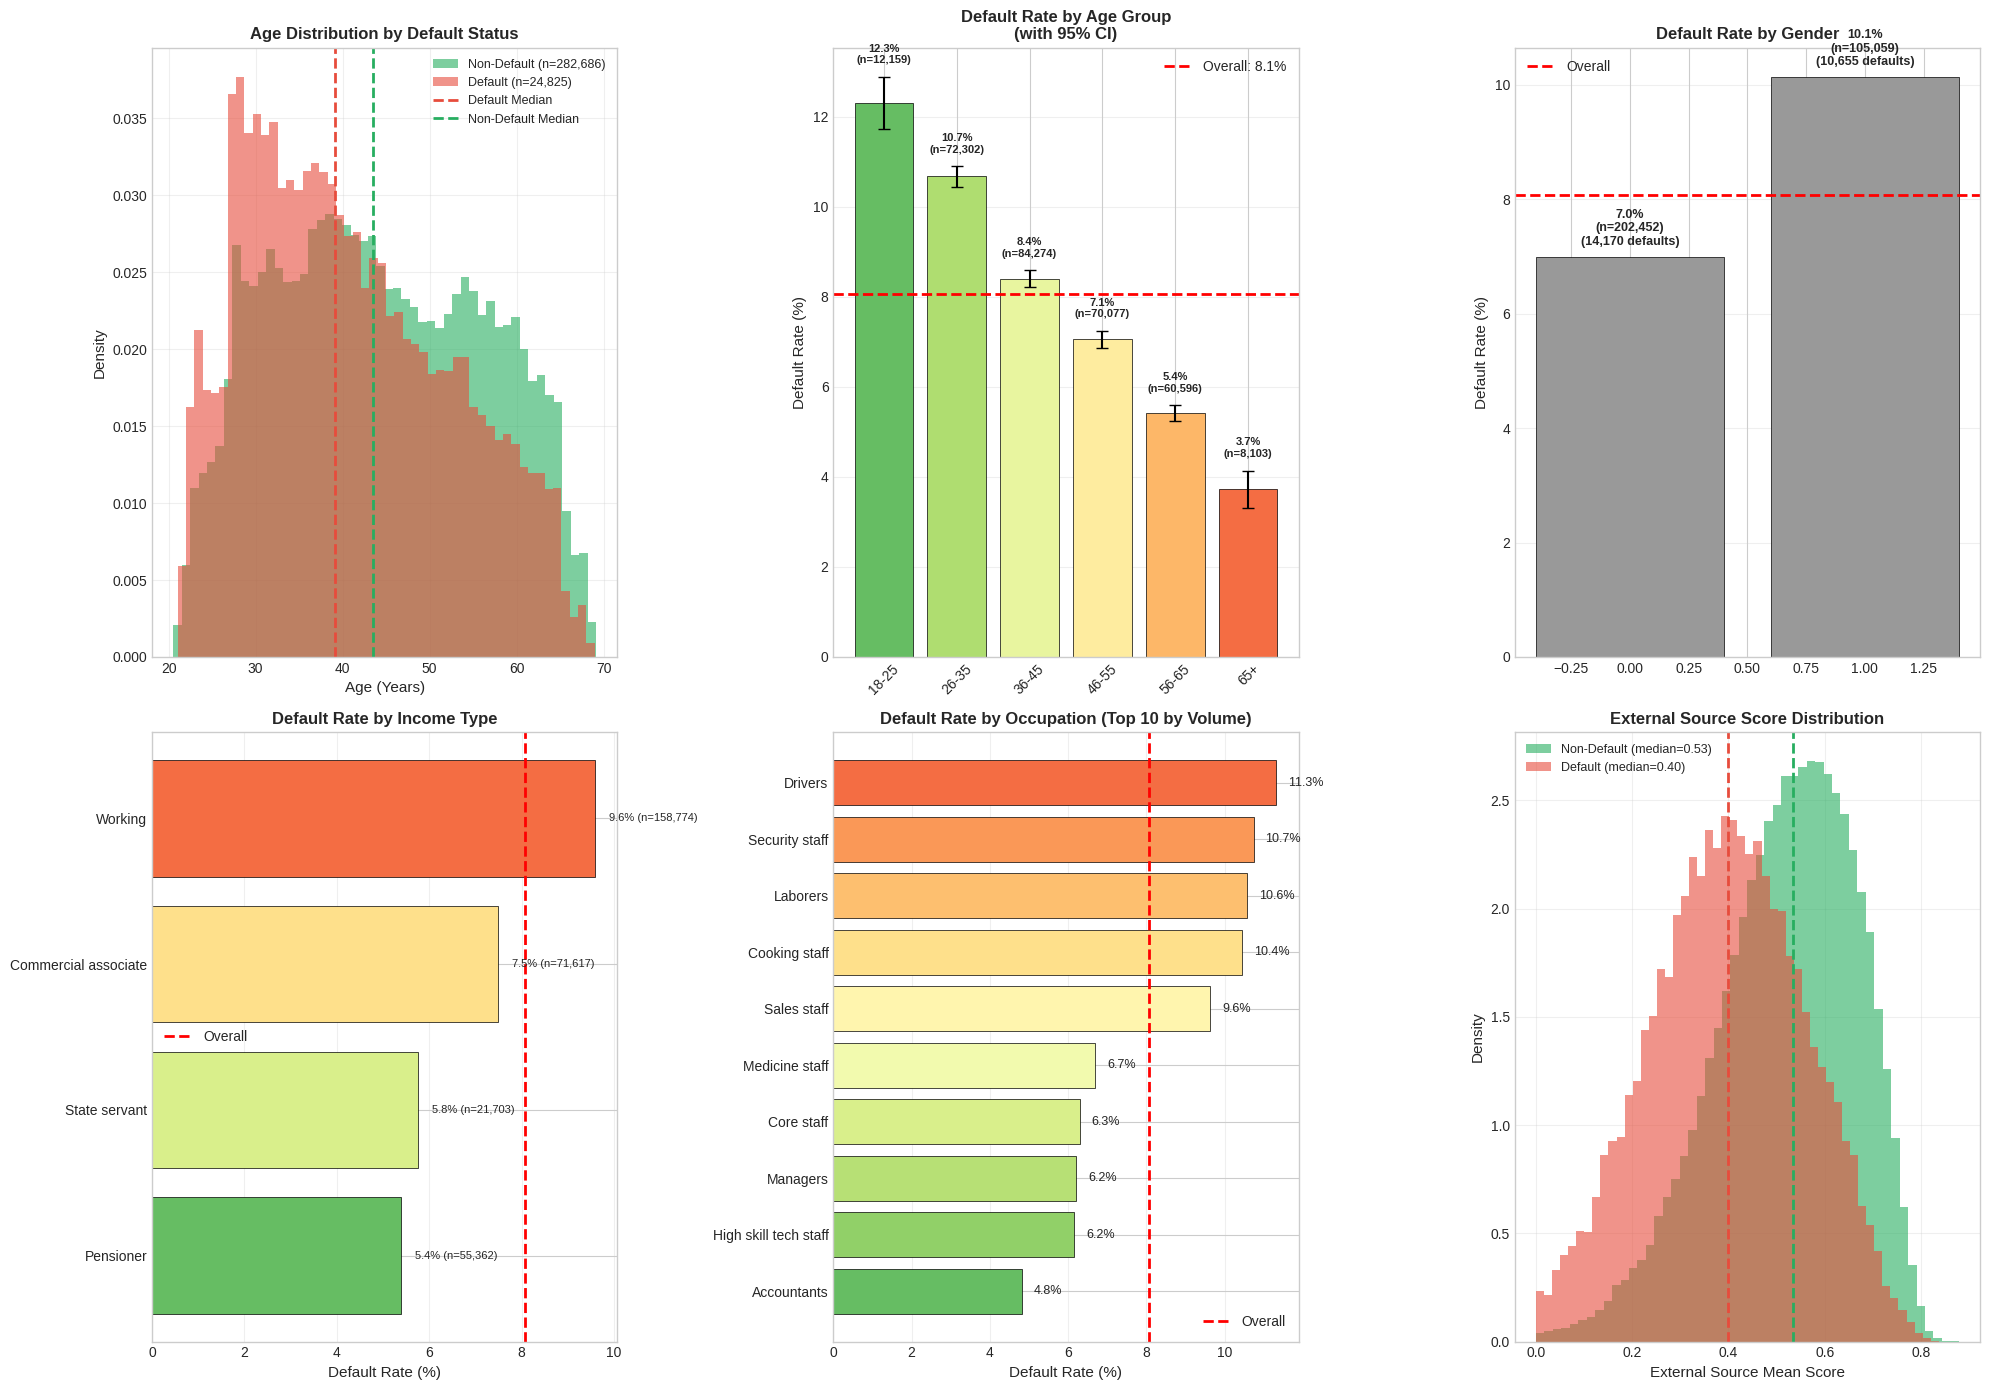

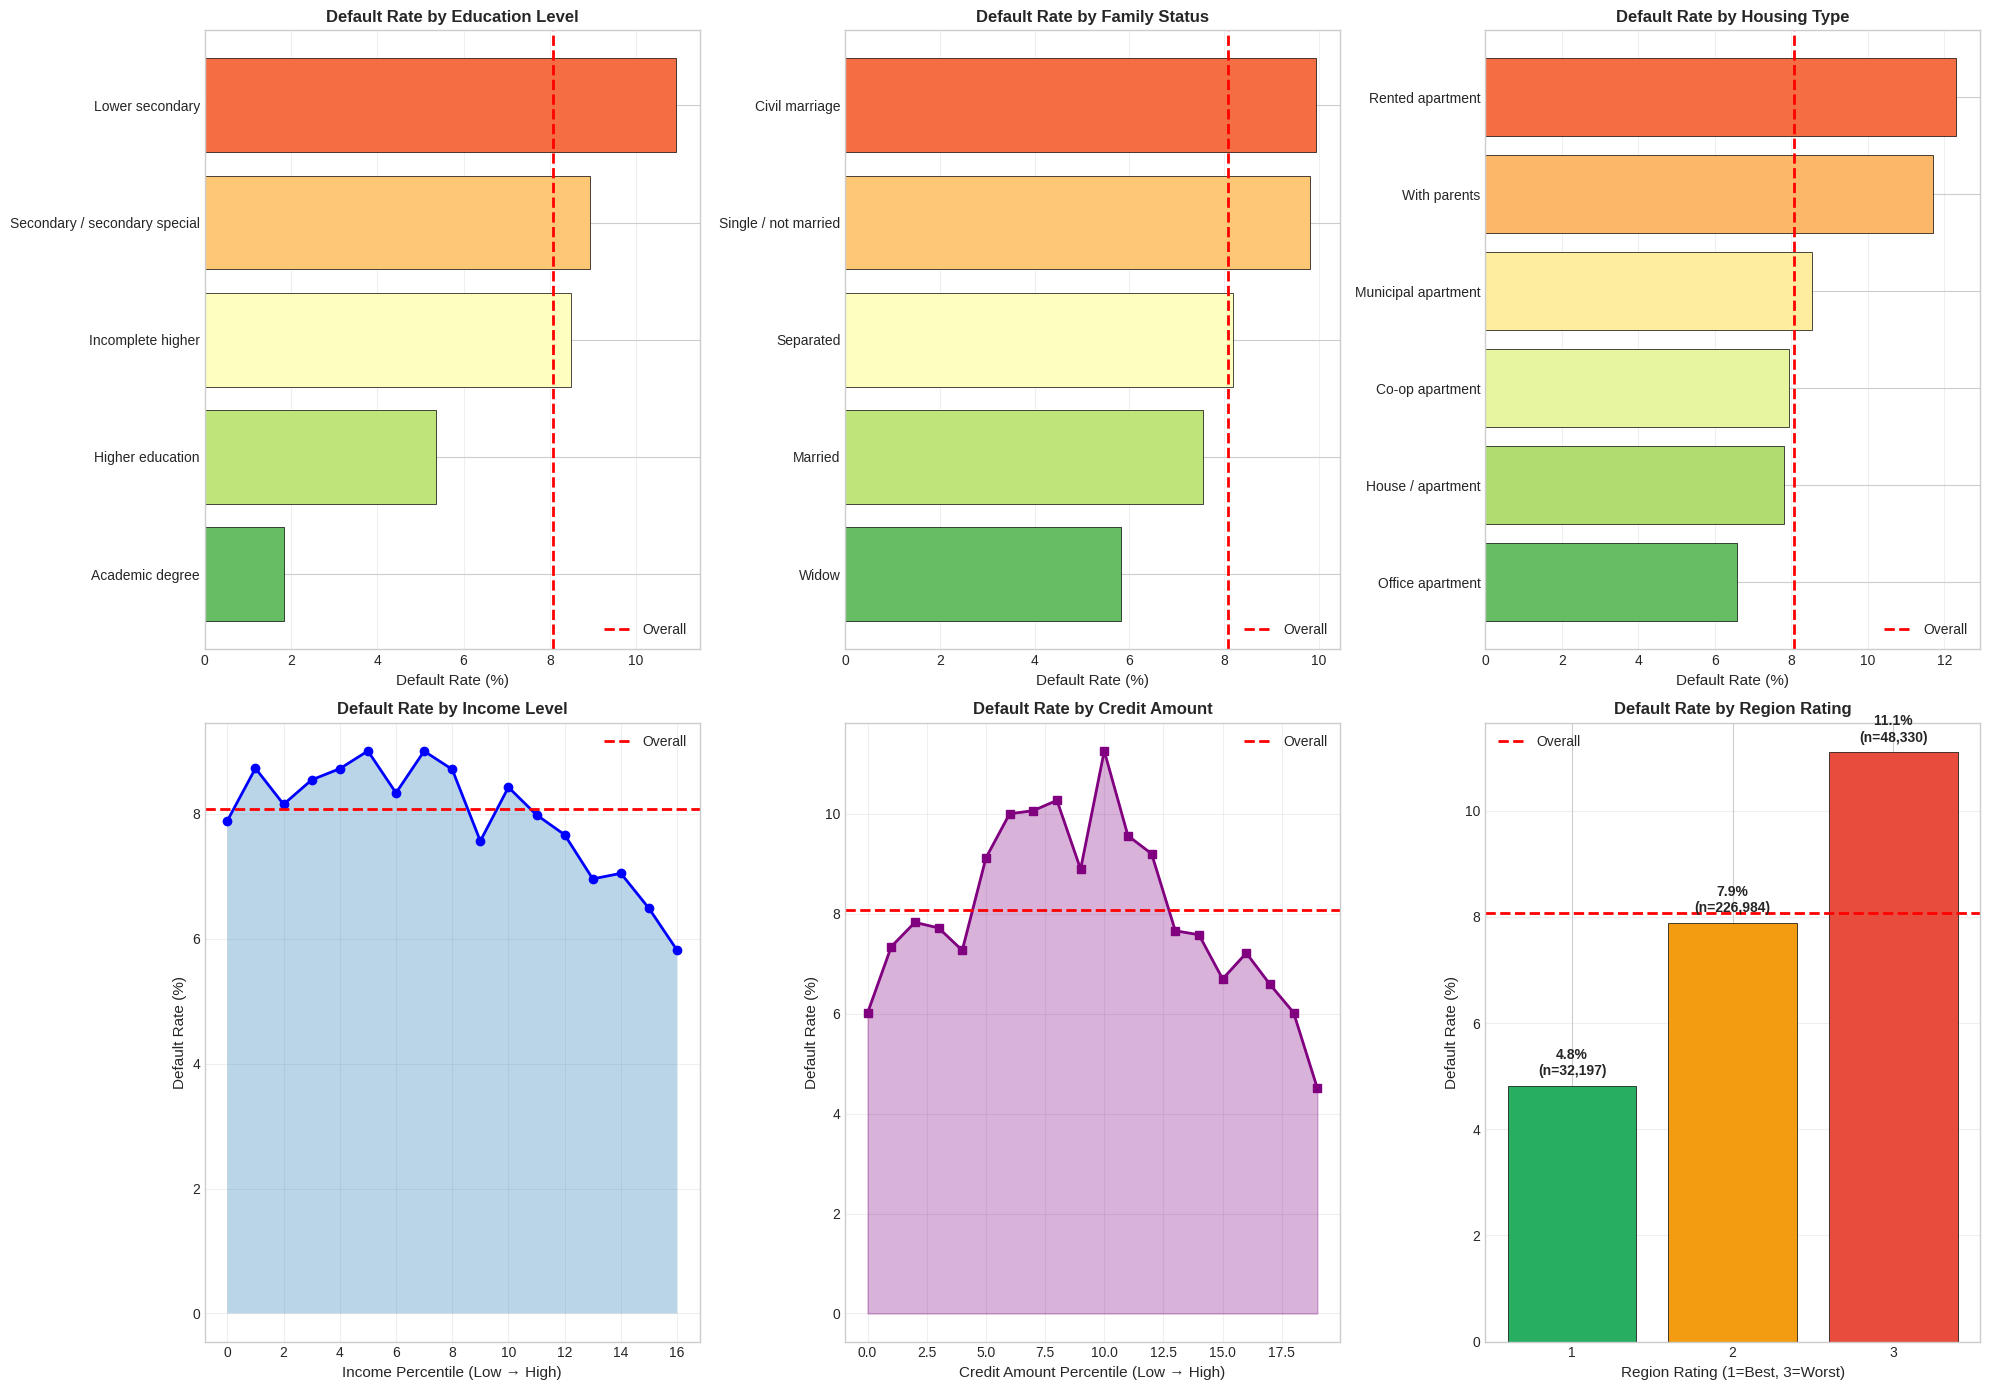


╔══════════════════════════════════════════════════════════════════════════════╗
║                      KEY DEMOGRAPHIC INSIGHTS                                ║
╚══════════════════════════════════════════════════════════════════════════════╝


OVERALL DEFAULT RATE: 8.07%

AGE ANALYSIS:
   • Young (<30 years): 11.46% default rate
   • Older (≥50 years): 5.72% default rate
   • Insight: Young borrowers are RISKIER
     (Difference: 5.7 percentage points)

GENDER ANALYSIS:
   • Male: nan% default rate
   • Female: nan% default rate
   • Insight: Females are RISKIER
     (Difference: nan percentage points)

INCOME ANALYSIS:
   • Low Income (≤25th percentile): 8.39% default rate
   • High Income (≥75th percentile): 7.13% default rate
   • Insight: Low income is RISKIER
     (Difference: 1.3 percentage points)

EXTERNAL SOURCE SCORE:
   • Low Score (<0.3): 23.14% default rate
   • High Score (>0.6): 2.92% default rate
   • Insight: External Source is the STRONGEST predictor!
     (Differen

In [5]:
#%%
# ============================================================================
# CELL 9: DEMOGRAPHIC ANALYSIS
# ============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                      DEMOGRAPHIC & SEGMENT ANALYSIS                          ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# =============================================================================
# FIGURE 1: BASIC DEMOGRAPHICS (6 plots)
# =============================================================================

fig = plt.figure(figsize=(20, 14))

# 1. Age Distribution by Default Status
ax1 = fig.add_subplot(2, 3, 1)
for t, color, label in [(0, '#27ae60', 'Non-Default'), (1, '#e74c3c', 'Default')]:
    data = df_train[df_train['TARGET'] == t]['AGE_YEARS'].dropna()
    ax1.hist(data, bins=50, alpha=0.6, color=color, label=f'{label} (n={len(data):,})', density=True)
ax1.axvline(df_train[df_train['TARGET']==1]['AGE_YEARS'].median(), color='#e74c3c', linestyle='--', linewidth=2, label='Default Median')
ax1.axvline(df_train[df_train['TARGET']==0]['AGE_YEARS'].median(), color='#27ae60', linestyle='--', linewidth=2, label='Non-Default Median')
ax1.set_xlabel('Age (Years)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Age Distribution by Default Status', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Default Rate by Age Group (with confidence indicator)
ax2 = fig.add_subplot(2, 3, 2)
age_stats = df_train.groupby('AGE_GROUP', observed=True)['TARGET'].agg(['mean', 'count', 'sum']).reset_index()
age_stats = age_stats.dropna()
age_stats['default_rate'] = age_stats['mean'] * 100
age_stats['ci'] = 1.96 * np.sqrt(age_stats['mean'] * (1 - age_stats['mean']) / age_stats['count']) * 100

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(age_stats)))
bars = ax2.bar(age_stats['AGE_GROUP'].astype(str), age_stats['default_rate'],
               yerr=age_stats['ci'], capsize=4, color=colors, edgecolor='black', linewidth=0.5)
ax2.axhline(y=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label=f'Overall: {df_train["TARGET"].mean()*100:.1f}%')
ax2.set_ylabel('Default Rate (%)', fontsize=11)
ax2.set_title('Default Rate by Age Group\n(with 95% CI)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar, (_, row) in zip(bars, age_stats.iterrows()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + row['ci'] + 0.3,
             f'{row["default_rate"]:.1f}%\n(n={int(row["count"]):,})', ha='center', fontsize=8, fontweight='bold')

# 3. Gender Analysis (with count)
ax3 = fig.add_subplot(2, 3, 3)
gender_stats = df_train.groupby('CODE_GENDER')['TARGET'].agg(['mean', 'count', 'sum']).reset_index()
gender_stats['default_rate'] = gender_stats['mean'] * 100

colors_gender = {'F': '#e91e63', 'M': '#2196f3', 'XNA': '#9e9e9e'}
bar_colors = [colors_gender.get(g, '#999999') for g in gender_stats['CODE_GENDER']]

bars = ax3.bar(gender_stats['CODE_GENDER'], gender_stats['default_rate'], color=bar_colors, edgecolor='black', linewidth=0.5)
ax3.axhline(y=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax3.set_ylabel('Default Rate (%)', fontsize=11)
ax3.set_title('Default Rate by Gender', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

for bar, (_, row) in zip(bars, gender_stats.iterrows()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{row["default_rate"]:.1f}%\n(n={int(row["count"]):,})\n({int(row["sum"]):,} defaults)',
             ha='center', fontsize=9, fontweight='bold')

# 4. Income Type Analysis
ax4 = fig.add_subplot(2, 3, 4)
income_stats = df_train.groupby('NAME_INCOME_TYPE')['TARGET'].agg(['mean', 'count', 'sum']).reset_index()
income_stats = income_stats[income_stats['count'] >= 50]  # Filter small groups
income_stats = income_stats.sort_values('mean', ascending=True)
income_stats['default_rate'] = income_stats['mean'] * 100

colors_income = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(income_stats)))
bars = ax4.barh(income_stats['NAME_INCOME_TYPE'], income_stats['default_rate'], color=colors_income, edgecolor='black', linewidth=0.5)
ax4.axvline(x=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax4.set_xlabel('Default Rate (%)', fontsize=11)
ax4.set_title('Default Rate by Income Type', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

for bar, (_, row) in zip(bars, income_stats.iterrows()):
    ax4.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f'{row["default_rate"]:.1f}% (n={int(row["count"]):,})', va='center', fontsize=8)

# 5. Top 10 Occupations by Volume
ax5 = fig.add_subplot(2, 3, 5)
occ_stats = df_train.groupby('OCCUPATION_TYPE')['TARGET'].agg(['mean', 'count', 'sum']).reset_index()
occ_stats = occ_stats[occ_stats['OCCUPATION_TYPE'] != 'XNA']
occ_stats = occ_stats.nlargest(10, 'count').sort_values('mean', ascending=True)
occ_stats['default_rate'] = occ_stats['mean'] * 100

colors_occ = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(occ_stats)))
bars = ax5.barh(occ_stats['OCCUPATION_TYPE'], occ_stats['default_rate'], color=colors_occ, edgecolor='black', linewidth=0.5)
ax5.axvline(x=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax5.set_xlabel('Default Rate (%)', fontsize=11)
ax5.set_title('Default Rate by Occupation (Top 10 by Volume)', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='x')

for bar, (_, row) in zip(bars, occ_stats.iterrows()):
    ax5.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f'{row["default_rate"]:.1f}%', va='center', fontsize=9)

# 6. External Source Distribution
ax6 = fig.add_subplot(2, 3, 6)
for t, color, label in [(0, '#27ae60', 'Non-Default'), (1, '#e74c3c', 'Default')]:
    data = df_train[df_train['TARGET'] == t]['EXT_SOURCE_MEAN'].dropna()
    ax6.hist(data, bins=50, alpha=0.6, color=color, label=f'{label} (median={data.median():.2f})', density=True)
ax6.axvline(df_train[df_train['TARGET']==1]['EXT_SOURCE_MEAN'].median(), color='#e74c3c', linestyle='--', linewidth=2)
ax6.axvline(df_train[df_train['TARGET']==0]['EXT_SOURCE_MEAN'].median(), color='#27ae60', linestyle='--', linewidth=2)
ax6.set_xlabel('External Source Mean Score', fontsize=11)
ax6.set_ylabel('Density', fontsize=11)
ax6.set_title('External Source Score Distribution', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_demographics_basic.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# FIGURE 2: ADVANCED DEMOGRAPHIC INSIGHTS (6 plots)
# =============================================================================

fig = plt.figure(figsize=(20, 14))

# 1. Education Type
ax1 = fig.add_subplot(2, 3, 1)
edu_stats = df_train.groupby('NAME_EDUCATION_TYPE')['TARGET'].agg(['mean', 'count']).reset_index()
edu_stats = edu_stats[edu_stats['count'] >= 50].sort_values('mean', ascending=True)
edu_stats['default_rate'] = edu_stats['mean'] * 100

colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(edu_stats)))
bars = ax1.barh(edu_stats['NAME_EDUCATION_TYPE'], edu_stats['default_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax1.axvline(x=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax1.set_xlabel('Default Rate (%)', fontsize=11)
ax1.set_title('Default Rate by Education Level', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Family Status
ax2 = fig.add_subplot(2, 3, 2)
family_stats = df_train.groupby('NAME_FAMILY_STATUS')['TARGET'].agg(['mean', 'count']).reset_index()
family_stats = family_stats[family_stats['count'] >= 50].sort_values('mean', ascending=True)
family_stats['default_rate'] = family_stats['mean'] * 100

colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(family_stats)))
bars = ax2.barh(family_stats['NAME_FAMILY_STATUS'], family_stats['default_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax2.axvline(x=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax2.set_xlabel('Default Rate (%)', fontsize=11)
ax2.set_title('Default Rate by Family Status', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Housing Type
ax3 = fig.add_subplot(2, 3, 3)
housing_stats = df_train.groupby('NAME_HOUSING_TYPE')['TARGET'].agg(['mean', 'count']).reset_index()
housing_stats = housing_stats[housing_stats['count'] >= 50].sort_values('mean', ascending=True)
housing_stats['default_rate'] = housing_stats['mean'] * 100

colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(housing_stats)))
bars = ax3.barh(housing_stats['NAME_HOUSING_TYPE'], housing_stats['default_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax3.axvline(x=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax3.set_xlabel('Default Rate (%)', fontsize=11)
ax3.set_title('Default Rate by Housing Type', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Income vs Default (Scatter with trend)
ax4 = fig.add_subplot(2, 3, 4)
# Create income bins
df_train['INCOME_BIN'] = pd.qcut(df_train['AMT_INCOME_TOTAL'].clip(upper=df_train['AMT_INCOME_TOTAL'].quantile(0.99)),
                                  q=20, duplicates='drop')
income_default = df_train.groupby('INCOME_BIN', observed=True)['TARGET'].agg(['mean', 'count']).reset_index()
income_default['income_mid'] = income_default['INCOME_BIN'].apply(lambda x: x.mid if hasattr(x, 'mid') else 0)
income_default = income_default.sort_values('income_mid')

ax4.plot(range(len(income_default)), income_default['mean']*100, 'b-o', linewidth=2, markersize=6)
ax4.fill_between(range(len(income_default)), income_default['mean']*100, alpha=0.3)
ax4.axhline(y=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax4.set_xlabel('Income Percentile (Low → High)', fontsize=11)
ax4.set_ylabel('Default Rate (%)', fontsize=11)
ax4.set_title('Default Rate by Income Level', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Credit Amount vs Default
ax5 = fig.add_subplot(2, 3, 5)
df_train['CREDIT_BIN'] = pd.qcut(df_train['AMT_CREDIT'].clip(upper=df_train['AMT_CREDIT'].quantile(0.99)),
                                  q=20, duplicates='drop')
credit_default = df_train.groupby('CREDIT_BIN', observed=True)['TARGET'].agg(['mean', 'count']).reset_index()
credit_default['credit_mid'] = credit_default['CREDIT_BIN'].apply(lambda x: x.mid if hasattr(x, 'mid') else 0)
credit_default = credit_default.sort_values('credit_mid')

ax5.plot(range(len(credit_default)), credit_default['mean']*100, 'purple', linewidth=2, marker='s', markersize=6)
ax5.fill_between(range(len(credit_default)), credit_default['mean']*100, alpha=0.3, color='purple')
ax5.axhline(y=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
ax5.set_xlabel('Credit Amount Percentile (Low → High)', fontsize=11)
ax5.set_ylabel('Default Rate (%)', fontsize=11)
ax5.set_title('Default Rate by Credit Amount', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Region Rating
ax6 = fig.add_subplot(2, 3, 6)
if 'REGION_RATING_CLIENT' in df_train.columns:
    region_stats = df_train.groupby('REGION_RATING_CLIENT')['TARGET'].agg(['mean', 'count']).reset_index()
    region_stats['default_rate'] = region_stats['mean'] * 100

    colors = ['#27ae60', '#f39c12', '#e74c3c'][:len(region_stats)]
    bars = ax6.bar(region_stats['REGION_RATING_CLIENT'].astype(str), region_stats['default_rate'],
                   color=colors, edgecolor='black', linewidth=0.5)
    ax6.axhline(y=df_train['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label='Overall')
    ax6.set_xlabel('Region Rating (1=Best, 3=Worst)', fontsize=11)
    ax6.set_ylabel('Default Rate (%)', fontsize=11)
    ax6.set_title('Default Rate by Region Rating', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')

    for bar, (_, row) in zip(bars, region_stats.iterrows()):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 f'{row["default_rate"]:.1f}%\n(n={int(row["count"]):,})', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('02_demographics_advanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Drop temporary columns
df_train = df_train.drop(['INCOME_BIN', 'CREDIT_BIN'], axis=1, errors='ignore')

# =============================================================================
# PRINT KEY DEMOGRAPHIC INSIGHTS
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                      KEY DEMOGRAPHIC INSIGHTS                                ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# Calculate key insights
overall_default = df_train['TARGET'].mean() * 100

# Age insights
young_default = df_train[df_train['AGE_YEARS'] < 30]['TARGET'].mean() * 100
old_default = df_train[df_train['AGE_YEARS'] >= 50]['TARGET'].mean() * 100

# Gender insights
male_default = df_train[df_train['CODE_GENDER'] == 'M']['TARGET'].mean() * 100
female_default = df_train[df_train['CODE_GENDER'] == 'F']['TARGET'].mean() * 100

# Income insights
low_income = df_train['AMT_INCOME_TOTAL'].quantile(0.25)
high_income = df_train['AMT_INCOME_TOTAL'].quantile(0.75)
low_income_default = df_train[df_train['AMT_INCOME_TOTAL'] <= low_income]['TARGET'].mean() * 100
high_income_default = df_train[df_train['AMT_INCOME_TOTAL'] >= high_income]['TARGET'].mean() * 100

# External source insights
low_ext = df_train[df_train['EXT_SOURCE_MEAN'] < 0.3]['TARGET'].mean() * 100 if 'EXT_SOURCE_MEAN' in df_train.columns else 0
high_ext = df_train[df_train['EXT_SOURCE_MEAN'] > 0.6]['TARGET'].mean() * 100 if 'EXT_SOURCE_MEAN' in df_train.columns else 0

print(f"""
OVERALL DEFAULT RATE: {overall_default:.2f}%

AGE ANALYSIS:
   • Young (<30 years): {young_default:.2f}% default rate
   • Older (≥50 years): {old_default:.2f}% default rate
   • Insight: {'Young borrowers are RISKIER' if young_default > old_default else 'Older borrowers are RISKIER'}
     (Difference: {abs(young_default - old_default):.1f} percentage points)

GENDER ANALYSIS:
   • Male: {male_default:.2f}% default rate
   • Female: {female_default:.2f}% default rate
   • Insight: {'Males are RISKIER' if male_default > female_default else 'Females are RISKIER'}
     (Difference: {abs(male_default - female_default):.1f} percentage points)

INCOME ANALYSIS:
   • Low Income (≤25th percentile): {low_income_default:.2f}% default rate
   • High Income (≥75th percentile): {high_income_default:.2f}% default rate
   • Insight: {'Low income is RISKIER' if low_income_default > high_income_default else 'High income is RISKIER'}
     (Difference: {abs(low_income_default - high_income_default):.1f} percentage points)

EXTERNAL SOURCE SCORE:
   • Low Score (<0.3): {low_ext:.2f}% default rate
   • High Score (>0.6): {high_ext:.2f}% default rate
   • Insight: External Source is the STRONGEST predictor!
     (Difference: {abs(low_ext - high_ext):.1f} percentage points)

═══════════════════════════════════════════════════════════════════════════════

BUSINESS RECOMMENDATIONS:

1. ENHANCED SCRUTINY for:
   • Young borrowers (under 30)
   • Low external source scores (<0.3)
   • Region rating 3 areas
   • Low income applicants

2. FAST-TRACK APPROVAL candidates:
   • Age 40-60 with stable employment
   • High external source scores (>0.6)
   • Region rating 1 areas
   • Higher education level

3. PRICING ADJUSTMENTS:
   • Risk-based pricing by age group
   • Premium for high-risk occupations
   • Discount for stable demographics

═══════════════════════════════════════════════════════════════════════════════
""")